## Importing Packages

In [1]:
from pathlib import Path
import pandas as pd
import numpy as np
import json
import re
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.ticker import MaxNLocator
from scipy.stats import pearsonr, spearmanr

## BACI data & volatility

In [31]:
# Loading the dataset
file_path = 'data/ukraine_wheat_maize_exports_1995_2023.csv'
df = pd.read_csv(file_path)

# Display the first few rows and info to confirm loading
display(df.head())
print(df.info())
print(df['product'].unique())
print(df['exporter'].unique())

,year,exporter_code,importer_code,product_code,value_thousands_usd,quantity,exporter,importer,product,value_million_usd
0,1995,804,203,100510,46.744,112.960,Ukraine,Czechia,Maize,0.046744
1,1995,804,233,100110,104.427,736.500,Ukraine,Estonia,Wheat,0.104427
2,1995,804,233,100510,45.531,261.250,Ukraine,Estonia,Maize,0.045531
3,1995,804,233,110100,847.335,5436.675,Ukraine,Estonia,Wheat,0.847335
4,1995,804,233,110311,7.436,67.800,Ukraine,Estonia,Wheat,0.007436


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7807 entries, 0 to 7806
Data columns (total 10 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   year                 7807 non-null   int64  
 1   exporter_code        7807 non-null   int64  
 2   importer_code        7807 non-null   int64  
 3   product_code         7807 non-null   int64  
 4   value_thousands_usd  7807 non-null   float64
 5   quantity             7789 non-null   float64
 6   exporter             7807 non-null   object 
 7   importer             7807 non-null   object 
 8   product              7807 non-null   object 
 9   value_million_usd    7807 non-null   float64
dtypes: float64(3), int64(4), object(3)
memory usage: 610.1+ KB
None
['Maize' 'Wheat']
['Ukraine']


In [32]:
# Filter for Wheat products
wheat_df = df[df['product'] == 'Wheat'].copy()

wheat_df['quantity'].fillna(0, inplace=True)
print(f"Missing quantities after fillna: {wheat_df['quantity'].isnull().sum()}")

invasion_year = 2022

yearly_exports = wheat_df.groupby(['importer', 'year'])['quantity'].sum().reset_index()

# Display the aggregated data
display(yearly_exports.head())
print(yearly_exports.info())

Missing quantities after fillna: 0


C:\Users\sammi\AppData\Local\Temp\ipykernel_25596\4154575789.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  wheat_df['quantity'].fillna(0, inplace=True)


,importer,year,quantity
0,Afghanistan,2008,58188.854
1,Afghanistan,2009,31995.386
2,Afghanistan,2010,676.500
3,Afghanistan,2016,10.075
4,Albania,1996,2957.250


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2369 entries, 0 to 2368
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   importer  2369 non-null   object 
 1   year      2369 non-null   int64  
 2   quantity  2369 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 55.7+ KB
None


In [33]:
# Split data into pre and post invasion periods
pre_invasion_df = yearly_exports[yearly_exports['year'] < invasion_year]
post_invasion_df = yearly_exports[yearly_exports['year'] >= invasion_year]

# calculate volatility
def calculate_volatility(series):
    if len(series) < 2:
        return np.nan # Need at least two data points to calculate change
    pct_change = series.pct_change().dropna()
    if len(pct_change) < 1:
        
         if len(pct_change) == 1 or np.allclose(pct_change, 0):
             return 0.0
         else:
             return np.nan 
    return pct_change.std()


pre_volatility = pre_invasion_df.groupby('importer')['quantity'].apply(calculate_volatility)
post_volatility = post_invasion_df.groupby('importer')['quantity'].apply(calculate_volatility)

volatility_comparison = pd.DataFrame({
    'pre_invasion_volatility': pre_volatility,
    'post_invasion_volatility': post_volatility
}).reset_index()

# Display the results
print("Volatility Comparison (Std Dev of Yearly % Change in Quantity):")
print(volatility_comparison.head())
print("\nCountries with NaN volatility (likely insufficient data points):")
print(volatility_comparison[volatility_comparison.isnull().any(axis=1)])


Volatility Comparison (Std Dev of Yearly % Change in Quantity):
      importer  pre_invasion_volatility  post_invasion_volatility
0  Afghanistan                 0.307072                       NaN
1      Albania                 1.977303                       NaN
2      Algeria                13.697952                       NaN
3      Andorra                      NaN                       NaN
4       Angola                82.093732                       NaN

Countries with NaN volatility (likely insufficient data points):
        importer  pre_invasion_volatility  post_invasion_volatility
0    Afghanistan                 0.307072                       NaN
1        Albania                 1.977303                       NaN
2        Algeria                13.697952                       NaN
3        Andorra                      NaN                       NaN
4         Angola                82.093732                       NaN
..           ...                      ...                       ..

In [34]:
# Calculate average quantity for each importer in both periods
pre_avg_quantity = pre_invasion_df.groupby('importer')['quantity'].mean()
post_avg_quantity = post_invasion_df.groupby('importer')['quantity'].mean()

# Combine results into a single DataFrame
avg_quantity_comparison = pd.DataFrame({
    'pre_invasion_avg_quantity': pre_avg_quantity,
    'post_invasion_avg_quantity': post_avg_quantity
}).reset_index()

epsilon = 1e-9
avg_quantity_comparison['pct_change_in_avg'] = (
    (avg_quantity_comparison['post_invasion_avg_quantity'] - avg_quantity_comparison['pre_invasion_avg_quantity']) /
    (avg_quantity_comparison['pre_invasion_avg_quantity'] + epsilon) * 100
)


# Display the results, perhaps sorted by the largest decrease
print("Comparison of Average Yearly Quantity (Pre- vs Post-Invasion):")
# Fill NaN in post_invasion_avg_quantity with 0 if you want to see countries that stopped importing
avg_quantity_comparison['post_invasion_avg_quantity'].fillna(0, inplace=True)
# Recalculate pct_change_in_avg after fillna
avg_quantity_comparison['pct_change_in_avg'] = (
    (avg_quantity_comparison['post_invasion_avg_quantity'] - avg_quantity_comparison['pre_invasion_avg_quantity']) /
    (avg_quantity_comparison['pre_invasion_avg_quantity'] + epsilon) * 100
)

print(avg_quantity_comparison.sort_values(by='pct_change_in_avg', ascending=True).head(20))

print("\nComparison for countries with highest pre-invasion average:")
print(avg_quantity_comparison.sort_values(by='pre_invasion_avg_quantity', ascending=False).head(20))


Comparison of Average Yearly Quantity (Pre- vs Post-Invasion):
                             importer  pre_invasion_avg_quantity  \
158                      South Africa              138330.419429   
134                              Peru              120342.142800   
20                            Bermuda               87152.152000   
124                           Nigeria               82072.533500   
25                             Brazil               60295.636500   
149                           Senegal               50789.996200   
118                           Namibia               38110.827000   
116                        Mozambique               37024.342571   
165                   Sudan (...2011)               36252.523889   
58                        El Salvador               24936.580000   
17       Belgium-Luxembourg (...1998)               23812.750000   
0                         Afghanistan               22717.703750   
103                        Luxembourg               2

C:\Users\sammi\AppData\Local\Temp\ipykernel_25596\4265387402.py:21: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  avg_quantity_comparison['post_invasion_avg_quantity'].fillna(0, inplace=True)


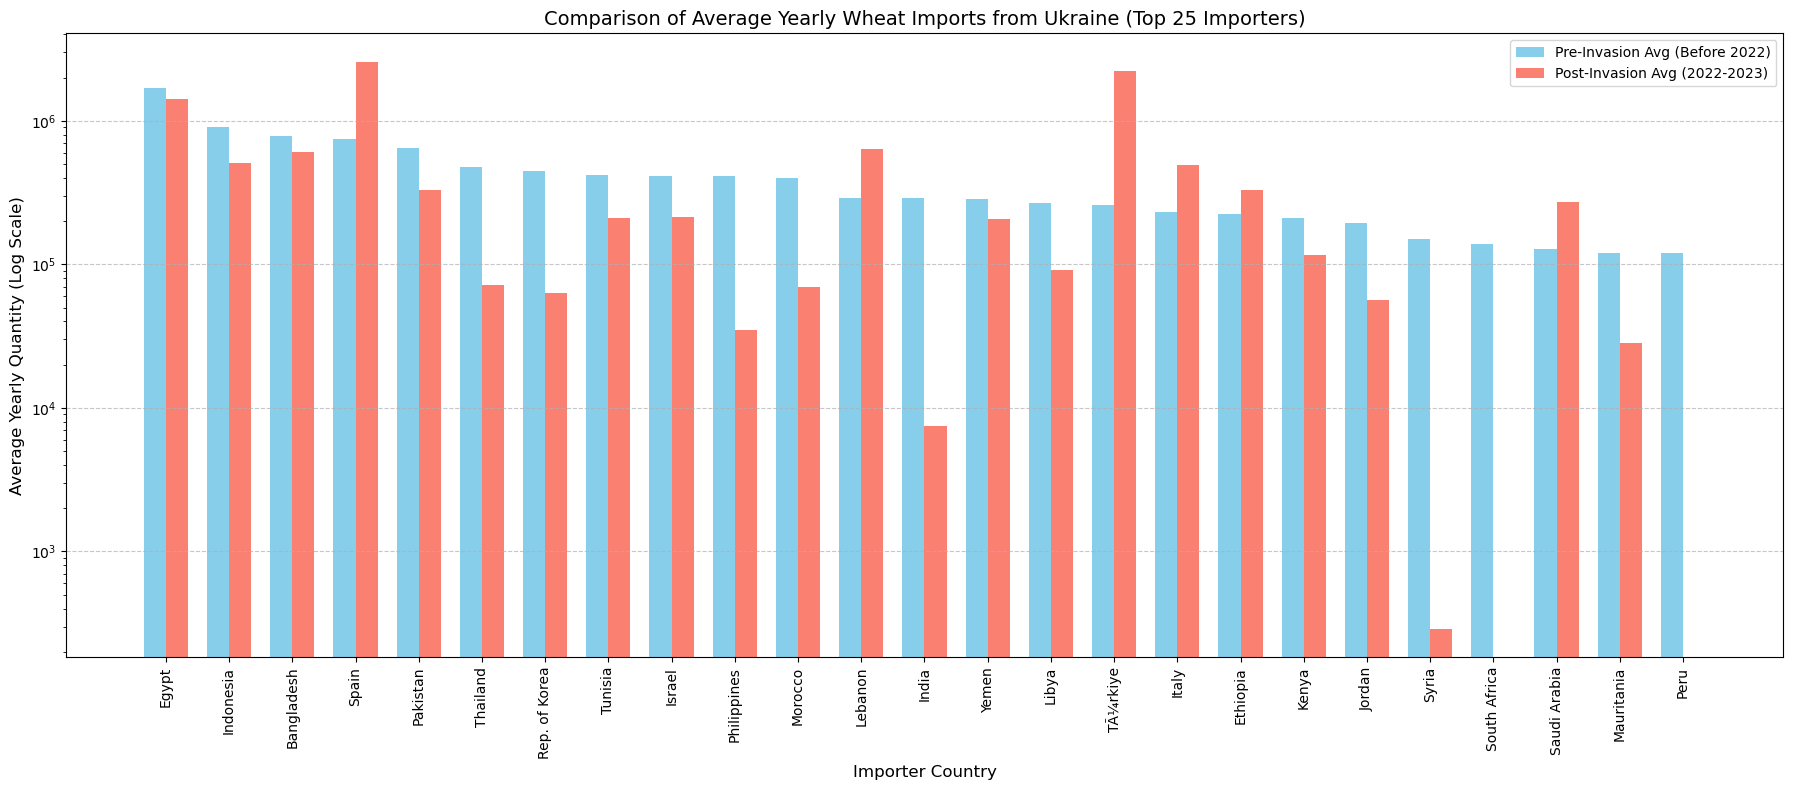

In [35]:
# Sort by pre-invasion average quantity to get top importers
top_importers_avg = avg_quantity_comparison.sort_values(by='pre_invasion_avg_quantity', ascending=False)

# Select top N importers
N = 25
top_n_importers = top_importers_avg.head(N)

# --- Visualization ---
plt.figure(figsize=(18, 8)) # Adjust figure size as needed

# Set up positions for the bars
bar_width = 0.35
index = np.arange(N)

# Plot pre-invasion bars
bar1 = plt.bar(index, top_n_importers['pre_invasion_avg_quantity'], bar_width, label='Pre-Invasion Avg (Before 2022)', color='skyblue')

# Plot post-invasion bars next to pre-invasion bars
bar2 = plt.bar(index + bar_width, top_n_importers['post_invasion_avg_quantity'], bar_width, label='Post-Invasion Avg (2022-2023)', color='salmon')

plt.xlabel('Importer Country', fontsize=12)
plt.ylabel('Average Yearly Quantity (e.g., tons)', fontsize=12) # Adjust unit label if known
plt.title(f'Comparison of Average Yearly Wheat Imports from Ukraine (Top {N} Importers)', fontsize=14)
plt.xticks(index + bar_width / 2, top_n_importers['importer'], rotation=90, ha='center', fontsize=10) # Rotate labels
plt.legend()
plt.tight_layout()
plt.yscale('log')
plt.ylabel('Average Yearly Quantity (Log Scale)')
plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

In [36]:
# Load data files
price_files = {
    "Indonesia": "data/FPMA data/Indonesia.csv",
    "Bangladesh": "data/FPMA data/Bangladesh.csv",
    "Egypt": "data/FPMA data/Egypt.csv",
    "Pakistan": "data/FPMA data/Pakistan.csv"
}

price_dfs = {}

for country, path in price_files.items():
    try:
        print(f"--- Loading {country} ({path}) ---")
        df_price = pd.read_csv(path)
        price_dfs[country] = df_price
        print(df_price.head())
        print(df_price.info())
        # Check for potential product columns
        product_cols = [col for col in df_price.columns if 'product' in col.lower() or 'item' in col.lower() or 'commodity' in col.lower()]
        if product_cols:
            print(f"Potential product columns: {product_cols}")
            # Display unique values in the first potential product column found
            print(f"Unique products in '{product_cols[0]}': {df_price[product_cols[0]].unique()[:20]}") # Show first 20 unique
        else:
            print("Could not automatically identify a product column.")
        print("-" * 30 + "\n")
    except FileNotFoundError:
        print(f"File not found: {path}")
    except Exception as e:
        print(f"Error loading {path}: {e}")

--- Loading Indonesia (data/FPMA data/Indonesia.csv) ---
         Date  Indonesia, RETAIL, National Average, Wheat (flour), IDR/Kg  \
0  01/01/2025                                            12237.0            
1  12/01/2024                                            12263.0            
2  11/01/2024                                            12277.0            
3  10/01/2024                                            12310.0            
4  09/01/2024                                            12340.0            

   Indonesia, RETAIL, National Average, Sugar, IDR/Kg  \
0                                            18249.0    
1                                            18051.0    
2                                            18036.0    
3                                            18015.0    
4                                            17942.0    

   Indonesia, RETAIL, National Average, Rice, IDR/Kg  \
0                                              14668   
1                        

In [37]:
# Assuming price_dfs is populated from the previous cell

reshaped_prices = []

col_pattern = re.compile(r"^(.*),\s*(\w+),\s*(.*),\s*(.*),\s*(\w+/\w+)$", re.IGNORECASE)

for country_name, df_price in price_dfs.items():
    print(f"--- Reshaping {country_name} ---")
    if 'Date' not in df_price.columns:
        print(f"Skipping {country_name}: 'Date' column not found.")
        continue

    # Melt the dataframe
    try:
        df_melted = df_price.melt(id_vars=['Date'], var_name='details', value_name='Price')
    except KeyError as e:
        print(f"Melting failed for {country_name}: {e}. Columns: {df_price.columns}")
        continue
        
    # Parse the 'details' column
    parsed_data = df_melted['details'].str.extract(col_pattern)
    if parsed_data.empty or parsed_data.isnull().all().all():
         print(f"Could not parse column headers in {country_name} using pattern.")
         simple_pattern = re.compile(r"^(\w+),\s*(.*),\s*(.*),\s*(\w+/\w+)$", re.IGNORECASE)
         parsed_data_simple = df_melted['details'].str.extract(simple_pattern)
         if not parsed_data_simple.empty and not parsed_data_simple.isnull().all().all():
             parsed_data_simple.columns = ['Market_Type', 'Market_Location', 'Product', 'Unit']
             parsed_data = parsed_data_simple
             # Add country name back if needed
             parsed_data['Country'] = country_name # Or parse from original col name if possible
         else:
            print("Simple pattern also failed.")
            parsed_data = pd.DataFrame({'Product': df_melted['details']}) # Fallback


    # Ensure parsed_data has expected columns even if regex fails partially
    expected_cols = ['Country', 'Market_Type', 'Market_Location', 'Product', 'Unit']
    for i, col in enumerate(expected_cols):
       if col not in parsed_data.columns:
         if len(parsed_data.columns) > i and hasattr(parsed_data, 'iloc'):
             parsed_data.rename(columns={parsed_data.columns[i]: col}, inplace=True)
         else:
            parsed_data[col] = pd.NA

    # Combine parsed data with melted dataframe
    df_long = pd.concat([df_melted[['Date', 'Price']], parsed_data], axis=1)

    # Data Cleaning
    df_long['Date'] = pd.to_datetime(df_long['Date'], errors='coerce') 
    df_long['Price'] = pd.to_numeric(df_long['Price'], errors='coerce') 
    df_long.dropna(subset=['Date', 'Price', 'Product'], inplace=True) 

    # Filter for Wheat/Flour
    df_wheat = df_long[df_long['Product'].str.contains('Wheat', case=False, na=False)].copy()

    if df_wheat.empty:
        print(f"No wheat products found in {country_name} after reshaping.")
    else:
        print(f"Found wheat products in {country_name}: {df_wheat['Product'].unique()}")
        # Add a country column if not already present from parsing
        if 'Country' not in df_wheat.columns or df_wheat['Country'].isnull().all():
             df_wheat['Country'] = country_name
        reshaped_prices.append(df_wheat)
    print("-" * 30 + "\n")


# Combine all reshaped wheat data into one DataFrame (if any exists)
if reshaped_prices:
    all_wheat_prices_df = pd.concat(reshaped_prices, ignore_index=True)
    print("--- Combined Wheat Price Data ---")
    print(all_wheat_prices_df.head())
    print(all_wheat_prices_df.info())
    print(f"Countries in combined data: {all_wheat_prices_df['Country'].unique()}")
    print(f"Products in combined data: {all_wheat_prices_df['Product'].unique()}")
else:
    print("No wheat price data found or processed from the specified files.")
    all_wheat_prices_df = pd.DataFrame() # Create empty df to avoid errors later



--- Reshaping Indonesia ---
Found wheat products in Indonesia: ['Wheat (flour)']
------------------------------

--- Reshaping Bangladesh ---
Found wheat products in Bangladesh: ['Wheat (flour)']
------------------------------

--- Reshaping Egypt ---
Found wheat products in Egypt: ['Wheat (flour)']
------------------------------

--- Reshaping Pakistan ---
Found wheat products in Pakistan: ['Wheat (flour)']
------------------------------

--- Combined Wheat Price Data ---
        Date    Price    Country Market_Type   Market_Location        Product  \
0 2025-01-01  12237.0  Indonesia      RETAIL  National Average  Wheat (flour)   
1 2024-12-01  12263.0  Indonesia      RETAIL  National Average  Wheat (flour)   
2 2024-11-01  12277.0  Indonesia      RETAIL  National Average  Wheat (flour)   
3 2024-10-01  12310.0  Indonesia      RETAIL  National Average  Wheat (flour)   
4 2024-09-01  12340.0  Indonesia      RETAIL  National Average  Wheat (flour)   

     Unit  
0  IDR/Kg  
1  IDR/Kg  

In [38]:
# Make sure all_wheat_prices_df exists and is not empty
if 'all_wheat_prices_df' not in locals() or all_wheat_prices_df.empty:
    print("Wheat price data ('all_wheat_prices_df') not available or empty. Skipping volatility analysis.")
else:
    print("--- Starting Price Volatility Analysis ---")
    print("Initial combined price data info:")
    print(all_wheat_prices_df.info())
    print(all_wheat_prices_df.head())

    # Ensure Date is sorted and set as index for resampling
    df_analysis = all_wheat_prices_df.sort_values(by=['Country', 'Date']).copy()
    df_analysis['Date'] = pd.to_datetime(df_analysis['Date'])
    df_analysis.set_index('Date', inplace=True)

    # Define invasion date
    invasion_date = pd.to_datetime('2022-02-01') 

    monthly_prices = df_analysis.groupby('Country')['Price'].resample('M').mean().reset_index()
    
    # Recalculate volatility function (can reuse from before if needed, copied here for clarity)
    def calculate_volatility(series):
        # Ensure series has enough non-NA points after potential resampling gaps
        series = series.dropna() 
        if len(series) < 2:
            return np.nan # Need at least two data points for change
        pct_change = series.pct_change().dropna()
        if len(pct_change) < 2: # Need at least two changes for std dev
             # Handle cases with only one change value
             # If the single change is ~0, volatility is 0, otherwise NaN is safer
             if len(pct_change) == 1 and np.isclose(pct_change.iloc[0], 0):
                 return 0.0
             else:
                 return np.nan # Not enough data for standard deviation
        return pct_change.std()

    # Split data based on the invasion date
    monthly_prices['Date'] = pd.to_datetime(monthly_prices['Date']) # Ensure date is datetime
    pre_invasion_prices = monthly_prices[monthly_prices['Date'] < invasion_date]
    post_invasion_prices = monthly_prices[monthly_prices['Date'] >= invasion_date]

    # Calculate volatility for each country
    pre_price_volatility = pre_invasion_prices.groupby('Country')['Price'].apply(calculate_volatility)
    post_price_volatility = post_invasion_prices.groupby('Country')['Price'].apply(calculate_volatility)

    # Combine results
    price_volatility_comparison = pd.DataFrame({
        'pre_invasion_price_volatility': pre_price_volatility,
        'post_invasion_price_volatility': post_price_volatility
    }).reset_index()

    # Display results
    print("\n--- Price Volatility Comparison (Std Dev of Monthly % Change) ---")
    print(price_volatility_comparison)

    # Calculate increase/decrease
    price_volatility_comparison['volatility_change'] = (
        price_volatility_comparison['post_invasion_price_volatility'] -
        price_volatility_comparison['pre_invasion_price_volatility']
    )
    print("\nChange in Volatility (Post - Pre):")
    print(price_volatility_comparison[['Country', 'volatility_change']].sort_values(by='volatility_change', ascending=False))


--- Starting Price Volatility Analysis ---
Initial combined price data info:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4061 entries, 0 to 4060
Data columns (total 7 columns):
 #   Column           Non-Null Count  Dtype         
---  ------           --------------  -----         
 0   Date             4061 non-null   datetime64[ns]
 1   Price            4061 non-null   float64       
 2   Country          4061 non-null   object        
 3   Market_Type      4061 non-null   object        
 4   Market_Location  4061 non-null   object        
 5   Product          4061 non-null   object        
 6   Unit             4061 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(5)
memory usage: 222.2+ KB
None
        Date    Price    Country Market_Type   Market_Location        Product  \
0 2025-01-01  12237.0  Indonesia      RETAIL  National Average  Wheat (flour)   
1 2024-12-01  12263.0  Indonesia      RETAIL  National Average  Wheat (flour)   
2 2024-11-01  12277

C:\Users\sammi\AppData\Local\Temp\ipykernel_25596\610207998.py:18: FutureWarning: 'M' is deprecated and will be removed in a future version, please use 'ME' instead.
  monthly_prices = df_analysis.groupby('Country')['Price'].resample('M').mean().reset_index()


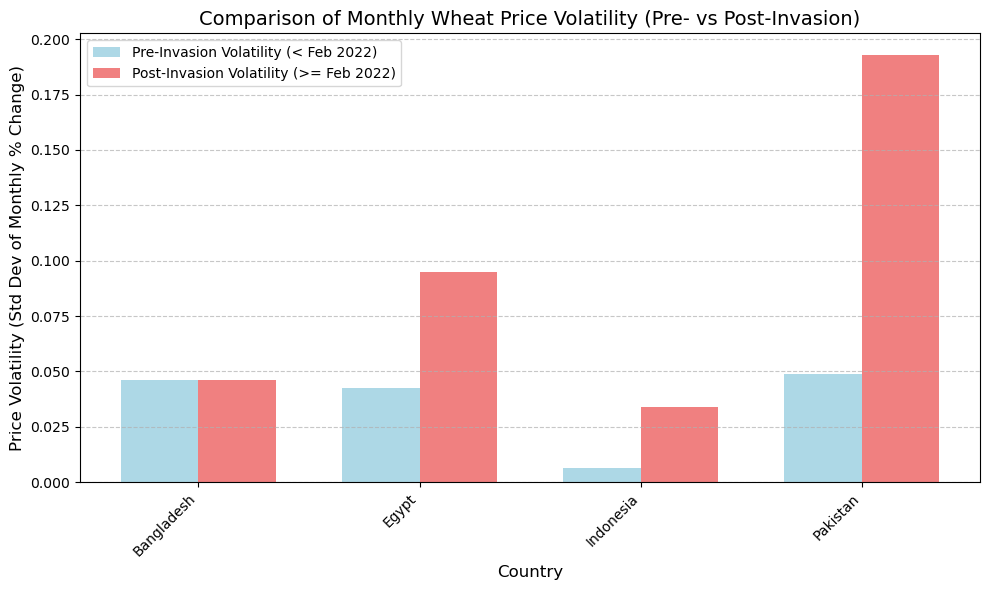


Price Volatility Data:
      Country  pre_invasion_price_volatility  post_invasion_price_volatility  \
0  Bangladesh                       0.045936                        0.046269   
1       Egypt                       0.042613                        0.095096   
2   Indonesia                       0.006324                        0.033775   
3    Pakistan                       0.048951                        0.192997   

   volatility_change  
0           0.000333  
1           0.052483  
2           0.027451  
3           0.144046  


In [39]:
# Make sure price_volatility_comparison exists and is not empty
if 'price_volatility_comparison' not in locals() or price_volatility_comparison.empty:
    print("Price volatility comparison data not available. Skipping visualization.")
else:
    # --- Visualization ---
    plt.figure(figsize=(10, 6)) # Adjust figure size as needed

    # Number of countries
    n_countries = len(price_volatility_comparison)

    # Set up positions for the bars
    bar_width = 0.35
    index = np.arange(n_countries)

    # Plot pre-invasion bars
    bar1 = plt.bar(index, price_volatility_comparison['pre_invasion_price_volatility'].fillna(0), bar_width,
                   label='Pre-Invasion Volatility (< Feb 2022)', color='lightblue') # Fillna for plotting if needed

    # Plot post-invasion bars next to pre-invasion bars
    bar2 = plt.bar(index + bar_width, price_volatility_comparison['post_invasion_price_volatility'].fillna(0), bar_width,
                   label='Post-Invasion Volatility (>= Feb 2022)', color='lightcoral') # Fillna for plotting if needed

    plt.xlabel('Country', fontsize=12)
    plt.ylabel('Price Volatility (Std Dev of Monthly % Change)', fontsize=12)
    plt.title('Comparison of Monthly Wheat Price Volatility (Pre- vs Post-Invasion)', fontsize=14)
    plt.xticks(index + bar_width / 2, price_volatility_comparison['Country'], rotation=45, ha='right', fontsize=10)
    plt.legend()
    plt.tight_layout() # Adjust layout
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()

    print("\nPrice Volatility Data:")
    print(price_volatility_comparison)

--- Calculating Rolling Price Volatility ---


C:\Users\sammi\AppData\Local\Temp\ipykernel_25596\1642189739.py:18: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_pct_change = country_prices['Price'].pct_change()
C:\Users\sammi\AppData\Local\Temp\ipykernel_25596\1642189739.py:18: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change or specify 'fill_method=None' to not fill NA values.
  monthly_pct_change = country_prices['Price'].pct_change()
C:\Users\sammi\AppData\Local\Temp\ipykernel_25596\1642189739.py:18: FutureWarning: The default fill_method='pad' in Series.pct_change is deprecated and will be removed in a future version. Either fill in any non-leading NA values prior to calling pct_change 

Calculated rolling volatility with window=2
        Date  Rolling_Volatility     Country
2 2008-03-31            0.016734  Bangladesh
3 2008-04-30            0.032612  Bangladesh
4 2008-05-31            0.000000  Bangladesh
5 2008-06-30            0.000000  Bangladesh
6 2008-07-31            0.106000  Bangladesh


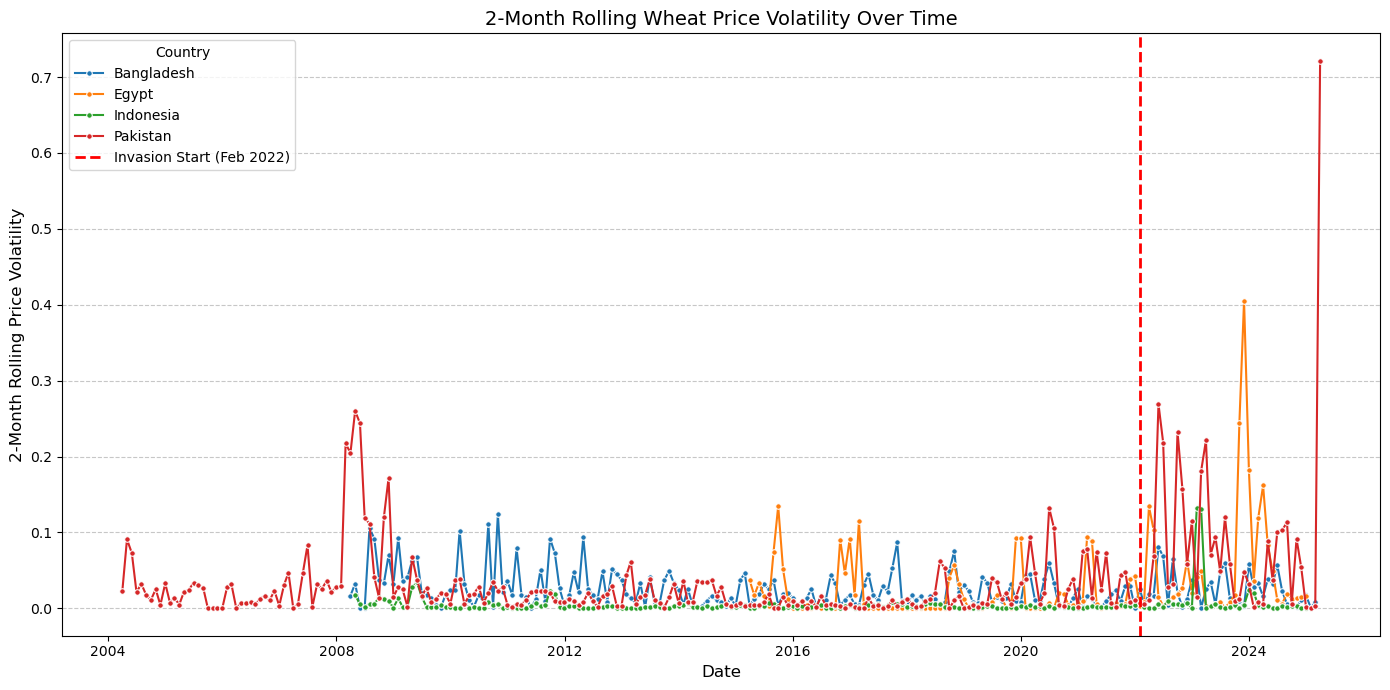

In [40]:
# Make sure monthly_prices exists and is not empty
if 'monthly_prices' not in locals() or monthly_prices.empty:
    print("Monthly price data ('monthly_prices') not available or empty. Skipping rolling volatility analysis.")
else:
    print("--- Calculating Rolling Price Volatility ---")

    # Define the rolling window size (e.g., 12 months)
    rolling_window = 2

    # Calculate rolling volatility for each country
    rolling_volatility_list = []
    for country in monthly_prices['Country'].unique():
        country_prices = monthly_prices[monthly_prices['Country'] == country].copy()
        # Sort by date just in case
        country_prices = country_prices.sort_values('Date').set_index('Date')
        
        # Calculate monthly percentage change
        monthly_pct_change = country_prices['Price'].pct_change()
        
        # Calculate rolling standard deviation of the percentage change
        # min_periods ensures we get output even before a full window is available (optional, can remove)
        rolling_std = monthly_pct_change.rolling(window=rolling_window, min_periods=max(2, rolling_window // 2)).std() 
        
        # Combine results
        rolling_df = pd.DataFrame({
            'Rolling_Volatility': rolling_std,
            'Country': country
        }).reset_index() # Bring Date back as a column
        
        rolling_volatility_list.append(rolling_df)

    if not rolling_volatility_list:
         print("Could not calculate rolling volatility for any country.")
    else:
        # Combine all countries' rolling volatility data
        all_rolling_volatility = pd.concat(rolling_volatility_list).dropna() # Drop NaNs from rolling calculation start

        if all_rolling_volatility.empty:
            print("Rolling volatility calculation resulted in empty data (possibly insufficient data points).")
        else:
            print(f"Calculated rolling volatility with window={rolling_window}")
            print(all_rolling_volatility.head())

            # --- Visualization ---
            plt.figure(figsize=(14, 7))

            # Plot rolling volatility using seaborn
            sns.lineplot(data=all_rolling_volatility, x='Date', y='Rolling_Volatility', hue='Country', marker='o', markersize=4)

            # Add a vertical line for the invasion date
            invasion_date_dt = pd.to_datetime('2022-02-01') # Ensure it's datetime
            plt.axvline(invasion_date_dt, color='r', linestyle='--', lw=2, label='Invasion Start (Feb 2022)')

            plt.xlabel('Date', fontsize=12)
            plt.ylabel(f'{rolling_window}-Month Rolling Price Volatility', fontsize=12)
            plt.title(f'{rolling_window}-Month Rolling Wheat Price Volatility Over Time', fontsize=14)
            plt.legend(title='Country')
            plt.grid(axis='y', linestyle='--', alpha=0.7)
            plt.tight_layout()
            plt.show()


## A look at the available FPMA data

In [ ]:
# filtering for country retail data by products that are in USD/Kg

data = pd.read_csv('data\FPMA data\\filteredDatasets\ALL_.csv')

drop_columns = [val for val in data.columns if "RETAIL" not in val or "USD/Kg" not in val or "National Average" not in val][1:]
data = data.drop(columns = drop_columns)

# filtering for Ukraine export data in USD/Kg from the FPMA data

ukraine_data = pd.read_csv('data\FPMA data\\filteredDatasets\ALL_.csv')

drop_columns = [val for val in ukraine_data.columns if "Ukraine" not in val or "EXPORT" not in val][1:]
ukraine_data = ukraine_data.drop(columns = drop_columns)

# joining with the Ukraine international prices from FPMA

data = data.merge(ukraine_data, how = 'left', on = 'Date')

# function to help us plot based on the country -- can be adjusted as needed
# References: https://www.freecodecamp.org/news/matplotlib-figure-size-change-plot-size-in-python/
#             https://stackoverflow.com/questions/10998621/rotate-axis-tick-labels

def line_plot(data, x, country):
    plt.figure(figsize = (50, 15))
    plt.xlabel("Date")
    plt.ylabel("Price (USD/kg)")
    plt.xticks(rotation = 45)
    column_names = data.columns
    for col in column_names:
        if country in col:
            plt.plot(x, data[col], label = (col.split(",")[0] + ":" + col.split(",")[3]))
            
        else:
            continue
    plt.plot(x, data["INTERNATIONAL PRICES, EXPORT, Ukraine, Wheat (milling, offer, f.o.b.), USD/Kg"], label = "Ukraine (Export): Wheat (milling)", linestyle = "--")
    plt.legend()
    plt.title(f'Retail Prices of {country} Products vs Export Prices of Ukraine Wheat')


<>:3: SyntaxWarning: invalid escape sequence '\F'
<>:10: SyntaxWarning: invalid escape sequence '\F'
<>:3: SyntaxWarning: invalid escape sequence '\F'
<>:10: SyntaxWarning: invalid escape sequence '\F'
C:\Users\sammi\AppData\Local\Temp\ipykernel_25596\2360981022.py:3: SyntaxWarning: invalid escape sequence '\F'
  data = pd.read_csv('data\FPMA data\\filteredDatasets\ALL_.csv')
C:\Users\sammi\AppData\Local\Temp\ipykernel_25596\2360981022.py:10: SyntaxWarning: invalid escape sequence '\F'
  ukraine_data = pd.read_csv('data\FPMA data\\filteredDatasets\ALL_.csv')


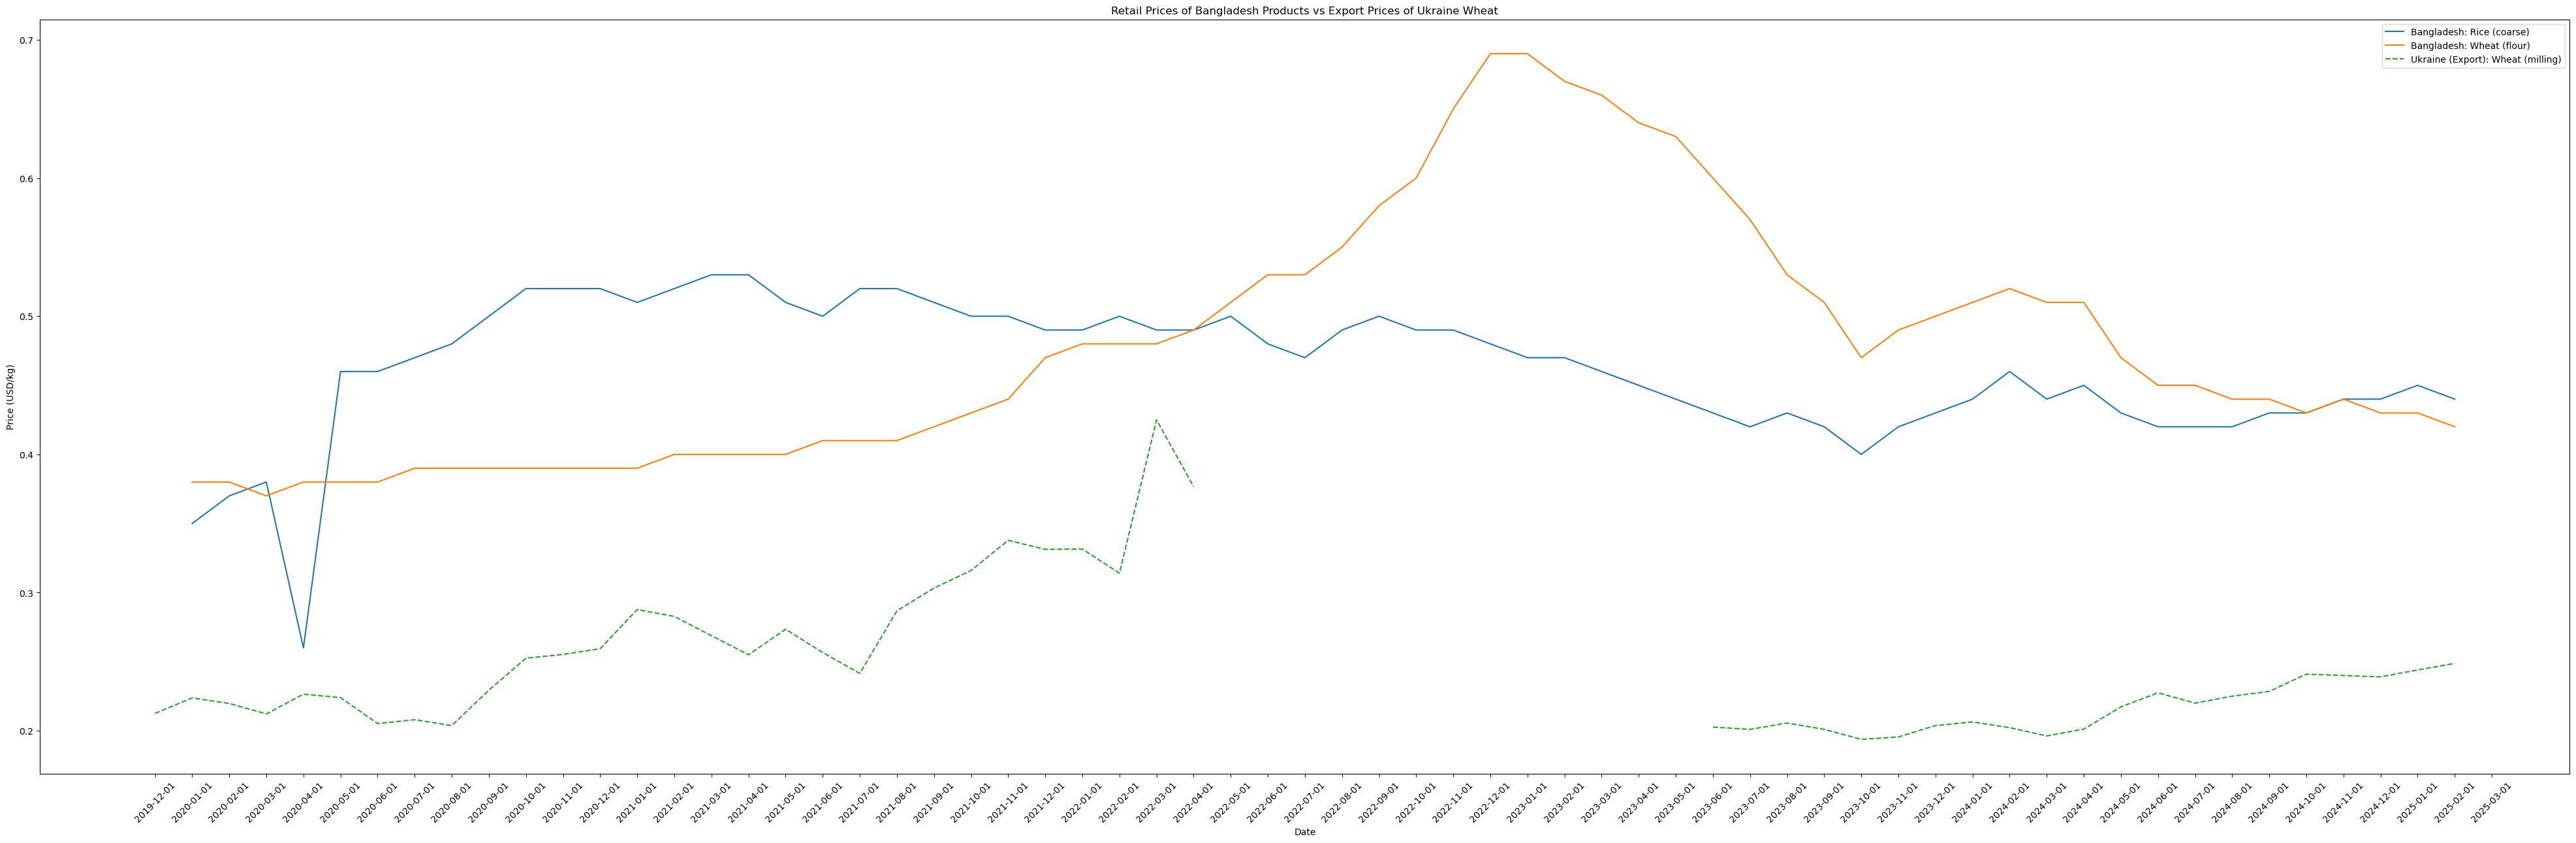

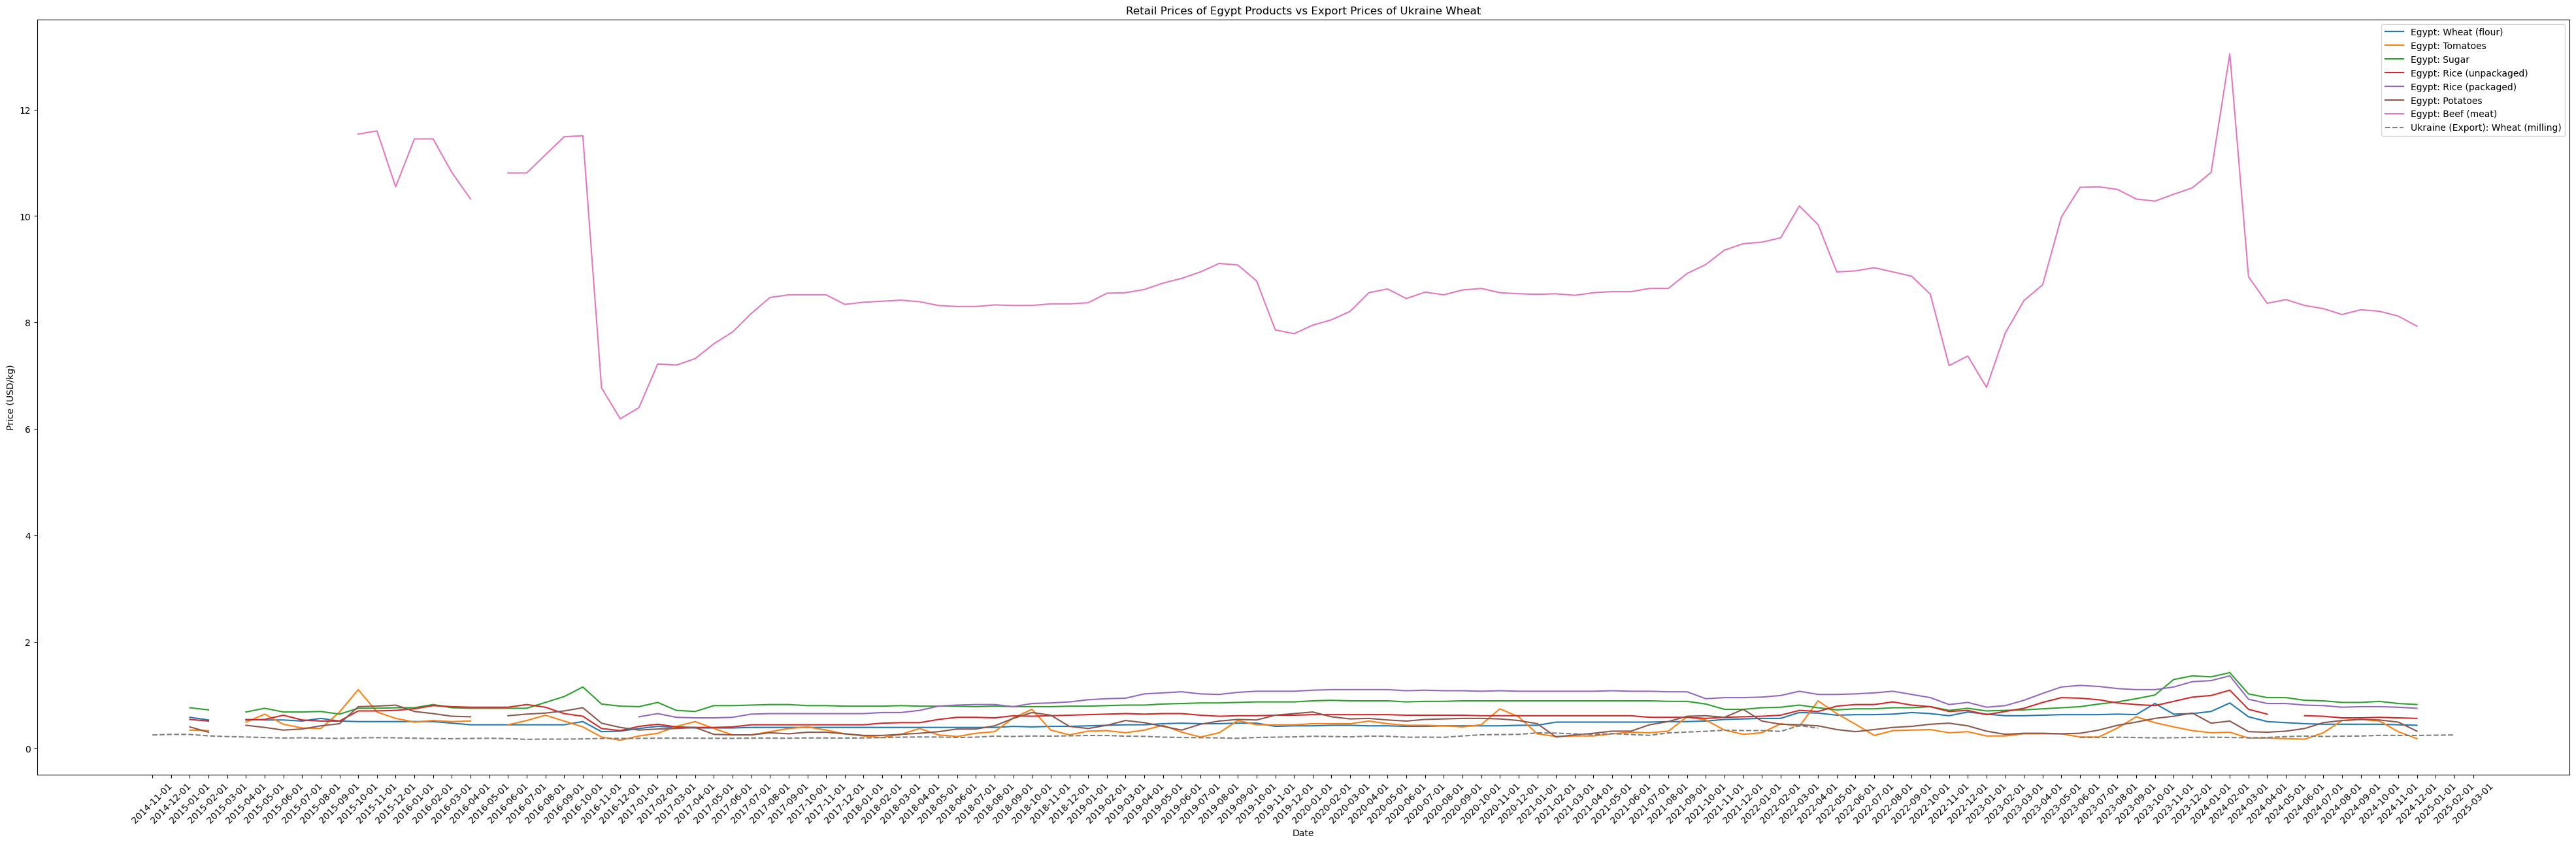

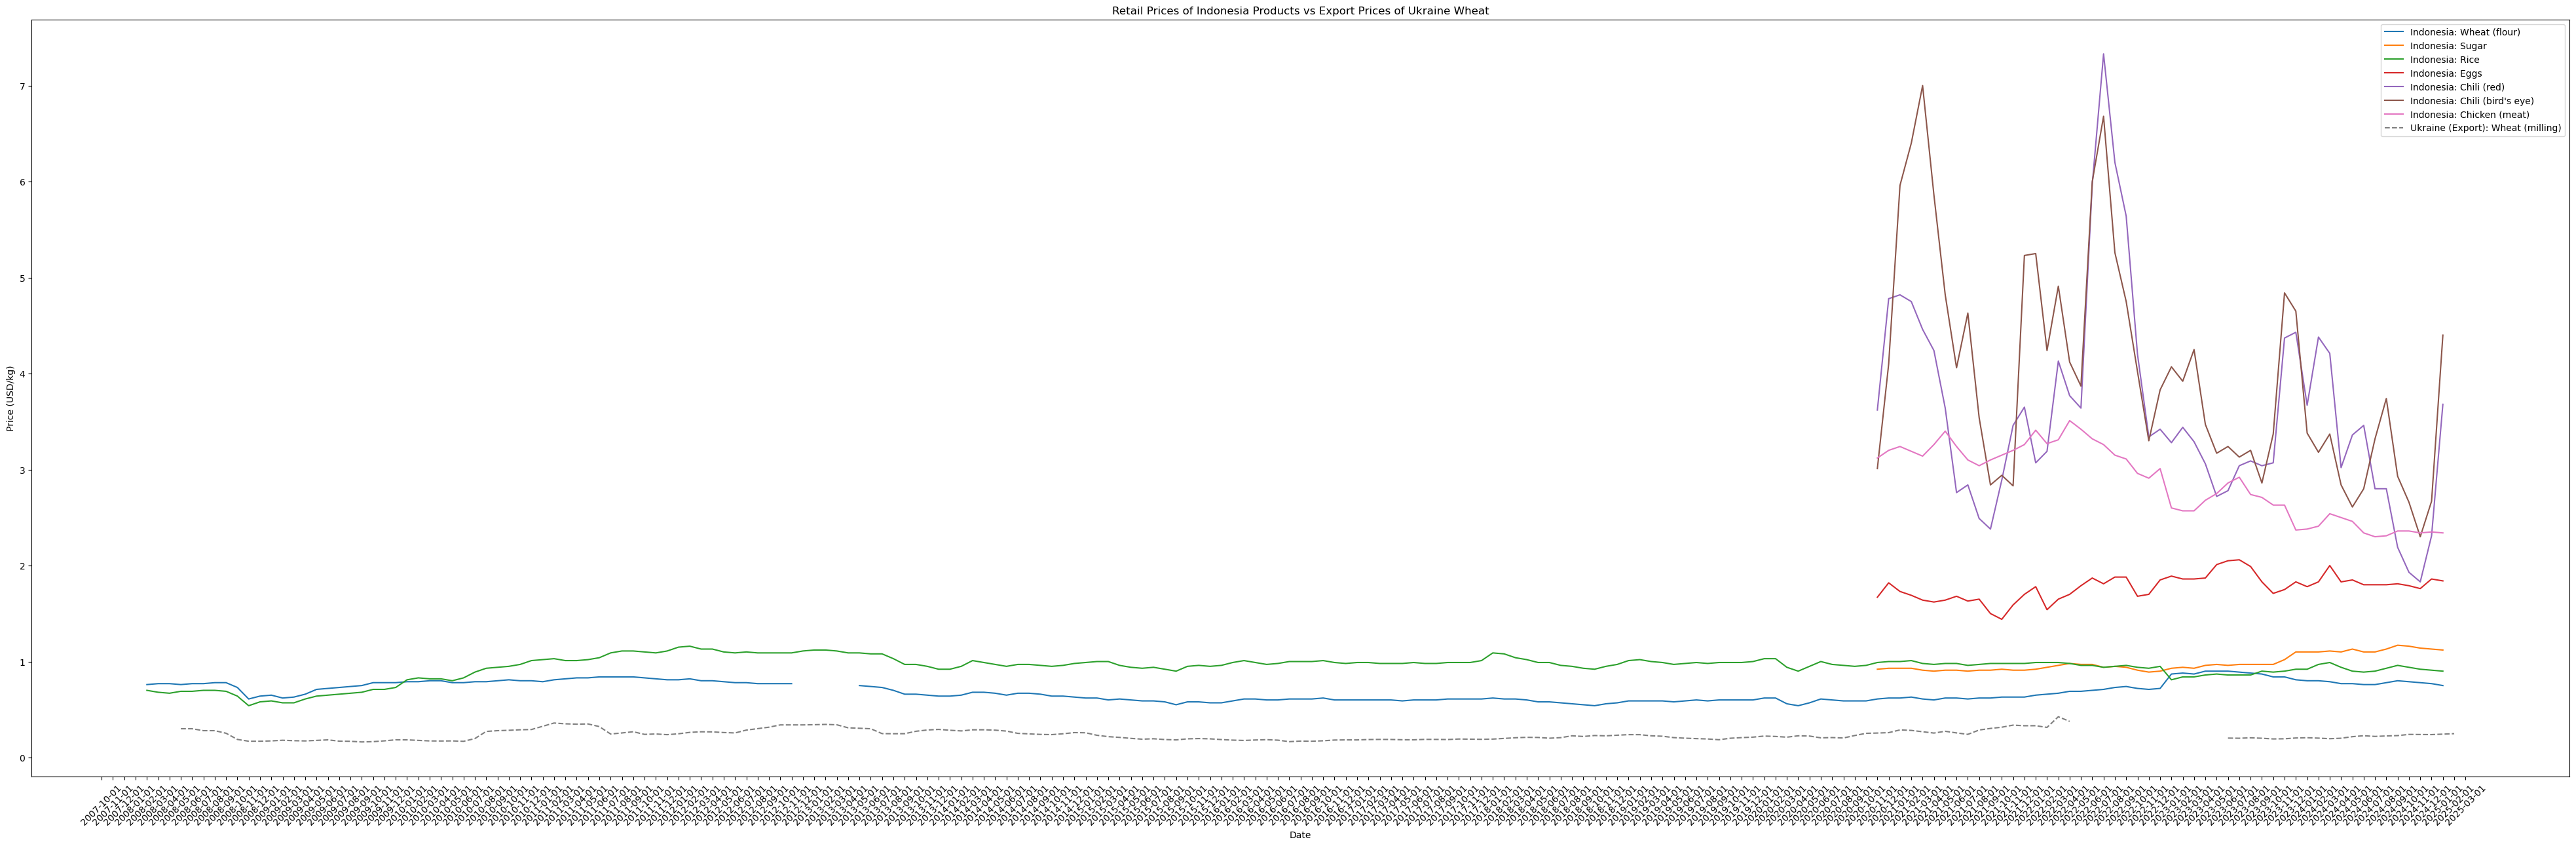

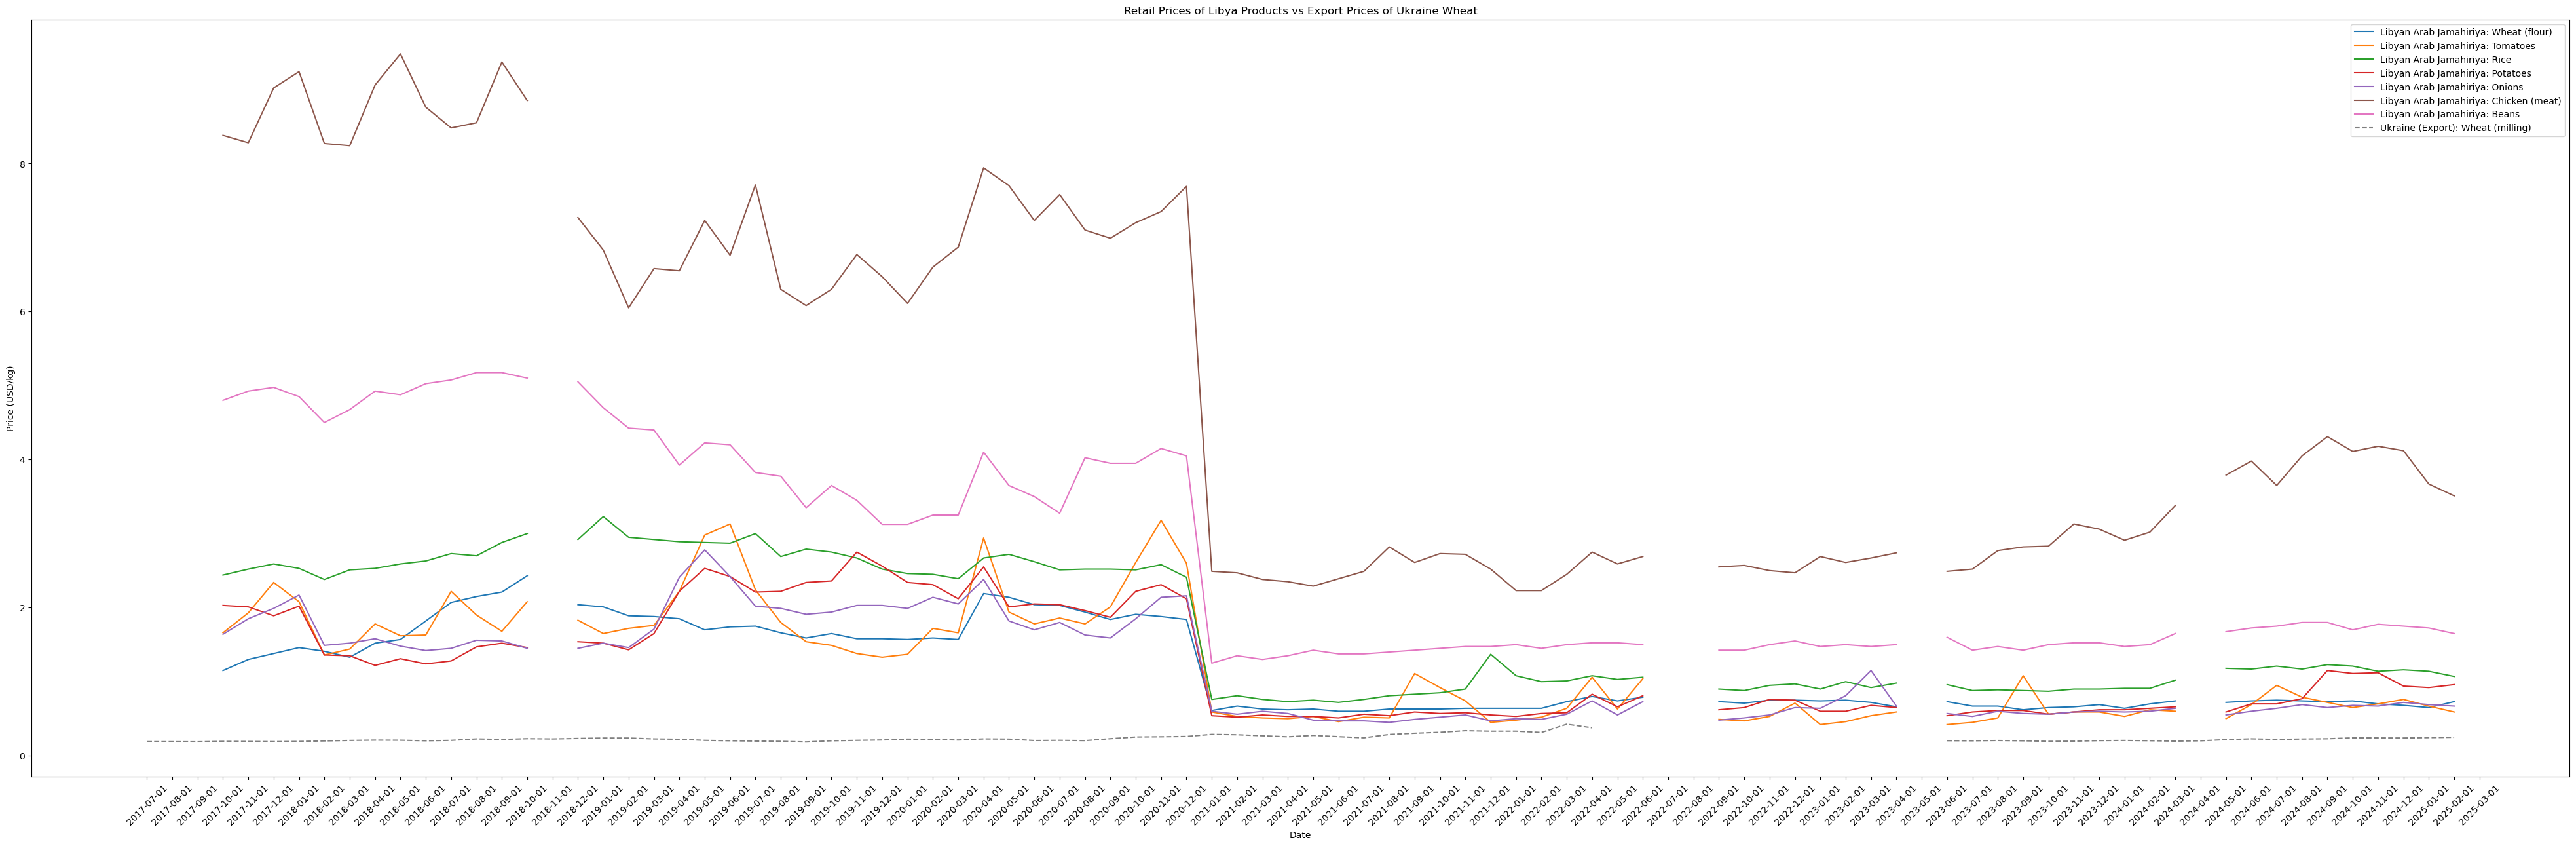

In [ ]:
# plot for Bangladesh 
line_plot(data[257: ], data["Date"][257: ], 'Bangladesh')

# plot for Egypt 
line_plot(data[196: ], data["Date"][196: ], 'Egypt')

# plot for Indonesia
line_plot(data[111: ], data["Date"][111: ], 'Indonesia')

# plot for Libya
line_plot(data[228: ], data["Date"][228: ], 'Libya')

<Axes: >

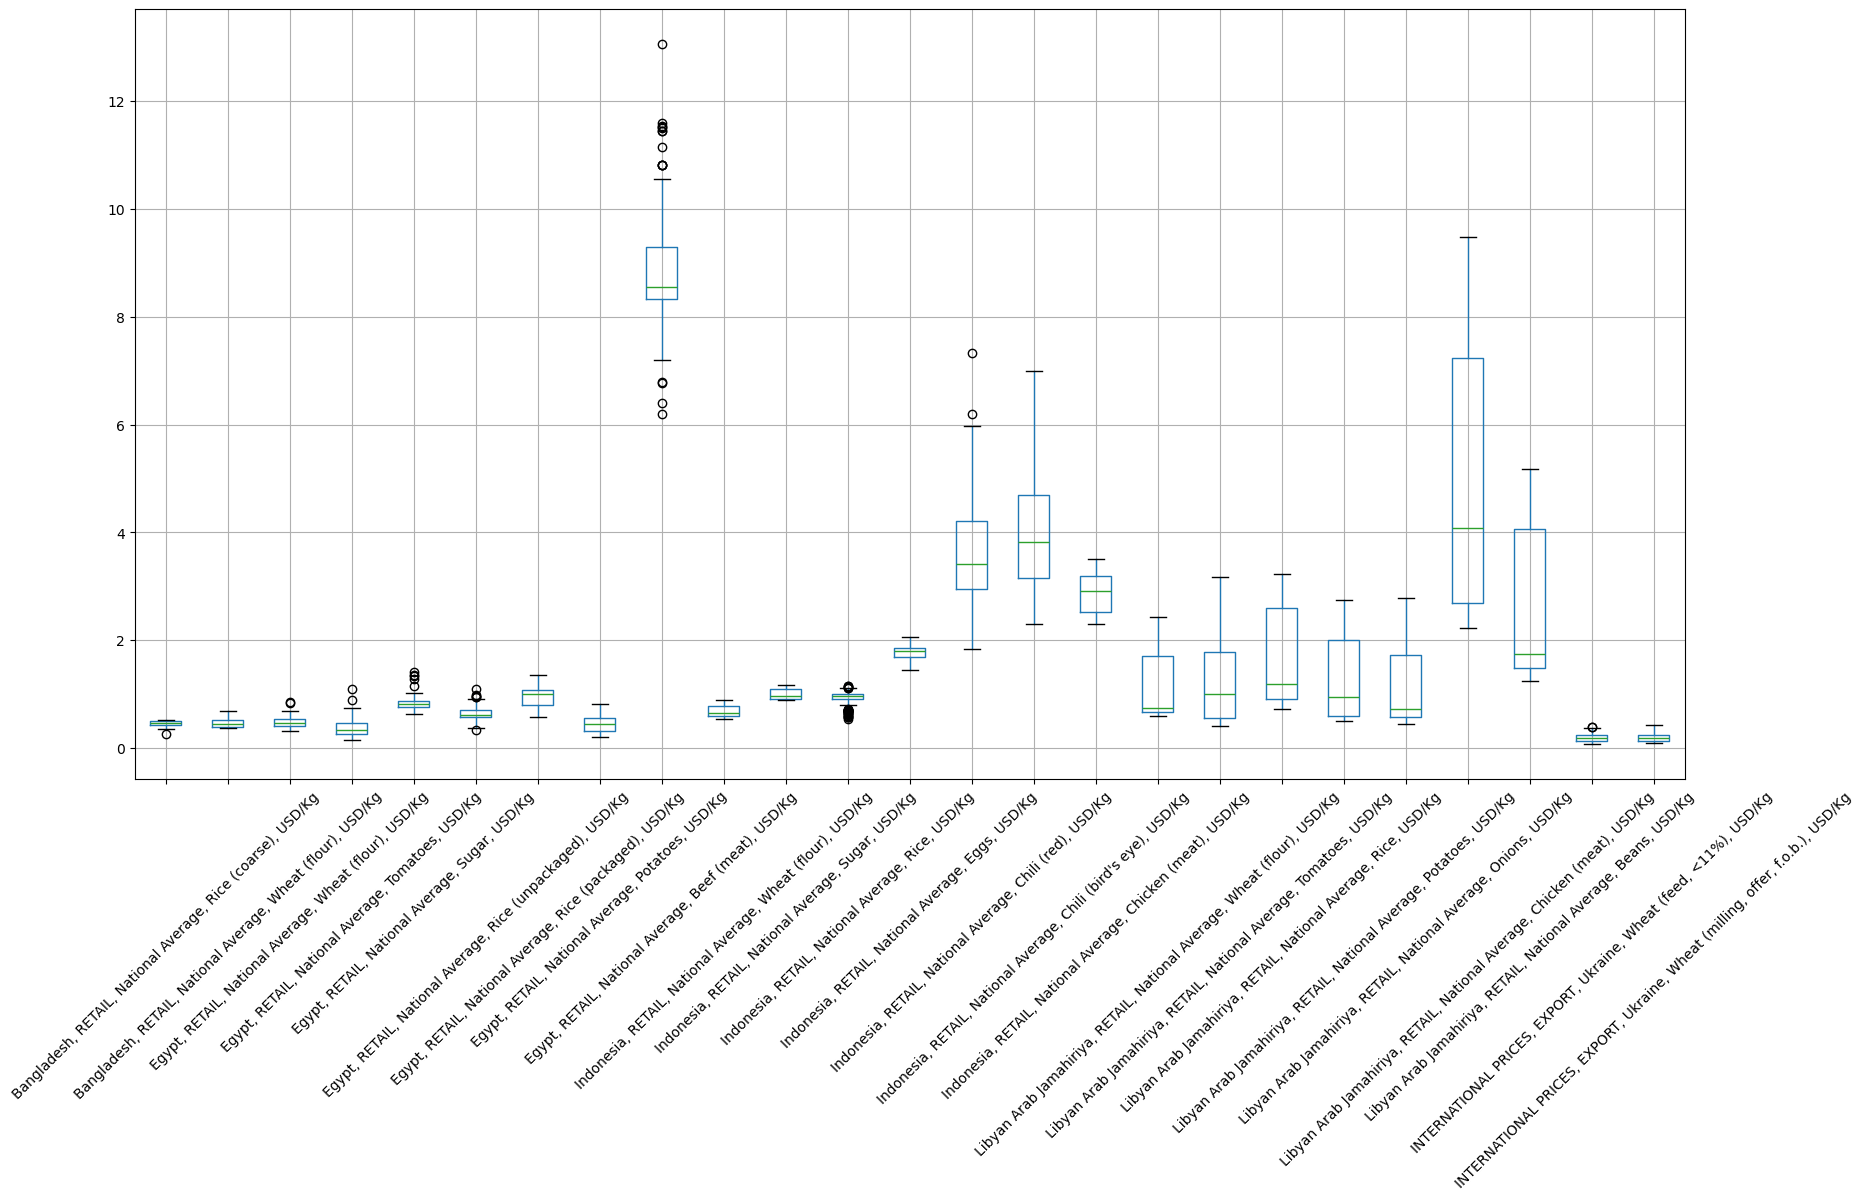

In [ ]:
# boxplot to get a quick gauge of outliers and distributions for each product

data.boxplot(figsize=(20,10), rot=45)

In [16]:
# Missing values for each country, product

print('Number of missing values:')
count_missing_values = data.isna().sum()
count_missing_values

Number of missing values:


Date                                                                               0
Bangladesh, RETAIL, National Average, Rice (coarse), USD/Kg                      259
Bangladesh, RETAIL, National Average, Wheat (flour), USD/Kg                      259
Egypt, RETAIL, National Average, Wheat (flour), USD/Kg                           202
Egypt, RETAIL, National Average, Tomatoes, USD/Kg                                203
Egypt, RETAIL, National Average, Sugar, USD/Kg                                   202
Egypt, RETAIL, National Average, Rice (unpackaged), USD/Kg                       203
Egypt, RETAIL, National Average, Rice (packaged), USD/Kg                         225
Egypt, RETAIL, National Average, Potatoes, USD/Kg                                203
Egypt, RETAIL, National Average, Beef (meat), USD/Kg                             211
Indonesia, RETAIL, National Average, Wheat (flour), USD/Kg                       122
Indonesia, RETAIL, National Average, Sugar, USD/Kg               

In [17]:
# should normalize -- min/max?

# should handle missing values -- drop?

## A closer look at the FPMA data and the relationship between wheat and rice prices (including a look at BACI import/export data)

In [18]:
# Garrit path: /mnt/c/Users/garri/Documents/SS2025/CIS635-DM/term-project-gjk

baseDir = Path("")
dataDir = Path(baseDir / "data")
FPMAdir = Path(dataDir / "FPMA data")
filteredDir = Path(FPMAdir / "filteredDatasets")

In [19]:
def uniqueColAttributes(saveCounts=False):
	"""
	* saveCounts - leave False
	Stores each portion of column name in 'attr' dict with instance counts.
	Returns attr - looks like:
	{
			"countries": {
					"Bangladesh": 30,
					"Egypt": 27,
					"Indonesia": 24,
					"Lebanon": 105,
					"Libyan Arab Jamahiriya": 192,
					"Pakistan": 42,
					"Ukraine": 9,
					"INTERNATIONAL PRICES": 2
			},
			"aggregate": {
					" RETAIL": 411,
					" WHOLESALE": 18,
					" EXPORT": 2
			},
			...
	}
	Check FPMA_Attribute_Counts.json to see full output
	"""
	attr = {
		"country": {},
		"aggregate": {},
		"market": {},
		"commodity": {},
		"unit": {},
	}
	for file in FPMAdir.iterdir():
		if file.suffix == ".csv":
			df = pd.read_csv(file)
			for col in df.columns.tolist():
				colAttr = col.split(",")
				if colAttr[0] == "Date":
					continue
				for i, key in enumerate(attr.keys()):
					if colAttr[i] not in attr[key]:
						attr[key][colAttr[i]] = 1
					else:
						attr[key][colAttr[i]] += 1

	if saveCounts:
		with open(FPMAdir / f"FPMA_Attribute_Counts.json", "w") as file:
			json.dump(attr, file, indent=2)

	return attr


def colCombsPresent(groupBy, saveCols):
	"""
	Nests column names in lists within keys containing the values associated with groupBy values. Check any FPMAcol_groupedBy... file for example
	* Args
			* groupBy - list containing 1+ of ['country', 'aggregate', 'market', 'commodity', 'unit']
			* saveCols - save dictionary of keys like 'Indonesia, Rice' based on groupBy values with all applicable actual columns in a list within
	* Returns
			* groups - (returns all under 'all' if empty)
	"""
	groups = {}
	attr = uniqueColAttributes()
	for file in FPMAdir.iterdir():
		if file.suffix == ".csv":
			df = pd.read_csv(file)
			for col in df.columns.tolist():
				if len(groupBy) > 0:
					groupKeyList = []
					for agg in groupBy:
						for val in attr[agg]:
							if val + "," in col or col.endswith(val):
								groupKeyList.append(val.strip())
					groupKey = ", ".join(groupKeyList)
					if groupKey not in groups:
						groups[groupKey] = [col]
					else:
						groups[groupKey].append(col)
				else:
					if "all" not in groups and col != "Date":
						groups["all"] = [col]
					elif col != "Date":
						groups["all"].append(col)

	if saveCols:
		with open(
			FPMAdir
			/ "filteredDatasets"
			/ f'FPMAcol_groupedBy_{"-".join(groupBy)}.json',
			"w",
		) as file:
			json.dump(groups, file, indent=2)

	return groups


def plotCheck(data, titleInfo):
	"""
	Randomly selects up to 3 columns and plots the self min-max normalized price over time. Meant to expose any issues with aggregation.
	* Args
			* data - output from grouping by certain attributes
			* titleInfo - list to be joined and used in title
	"""

	randCols = np.random.choice(data.columns[1:], size=3, replace=False)

	for col in randCols:
		normedPrices = (data[col] - data[col].min()) / (
			data[col].max() - data[col].min()
		)
		plt.plot(data["Date"], normedPrices, label=col)

	plt.gca().xaxis.set_major_locator(MaxNLocator(integer=True, prune="both"))
	plt.xticks(rotation=60)
	plt.gca().xaxis.set_major_formatter(plt.matplotlib.dates.DateFormatter("%Y-%m-%d"))

	plt.xlabel("Date")
	plt.title(f"{'-'.join(titleInfo)} Sanity Check")
	plt.ylabel("Min-Max Normed Price")
	plt.legend(fontsize=8, bbox_to_anchor=(1, 1))
	plt.show()


def getSpecificData(groupBy, saveCols=False, saveCSV=False, sanityCheck=False):
	"""
	* Args
			* groupBy -
					* dictionary like {
					* 	"commodity": "Wheat (flour)",
					* 	"country": "Indonesia"
					* }
			* saveCols - Saves the grouped columns if true (probably leave false)
			* saveCSV - Saves csv if true (probably leave true)
	* returns
			* data - DataFrame filtered by key-value pairs provided in groupBy.
	"""

	data = pd.DataFrame()
	groupedCols = colCombsPresent(list(groupBy.keys()), saveCols)
	if "all" in groupedCols:
		colsToUse = groupedCols["all"]
	else:
		groupKey = ", ".join(groupBy.values())
		colsToUse = groupedCols[groupKey]

	if sanityCheck:
		print(f"First 5 columns used: [{'], ['.join(colsToUse[:5])}].")
	if saveCSV:
		print(f"Creating ALL_{'-'.join(groupBy.values())}.csv")

	for file in FPMAdir.iterdir():
		if file.suffix == ".csv":
			df = pd.read_csv(file)
			matchingCols = [col for col in colsToUse if col in df.columns]
			if matchingCols:
				if "Date" not in matchingCols:
					matchingCols.insert(0, "Date")
				data = pd.concat([data, df[matchingCols]], ignore_index=True)

	data.reset_index()
	data["Date"] = pd.to_datetime(data["Date"])
	data = data.groupby("Date", as_index=False).agg("first")
	data = data.sort_values(by="Date")

	if sanityCheck:
		print(f"Shape: {data.shape}")
		display(data.head(2))
		plotCheck(data, groupBy.values())

	if saveCSV:
		Path(FPMAdir / "filteredDatasets").mkdir(exist_ok=True)
		data.to_csv(
			FPMAdir / "filteredDatasets" / f"ALL_{'-'.join(groupBy.values())}.csv",
			index=False,
		)
		print("Saved.")

	return data


""" Example Usage

- Check filteredDatasets/FPMA_Attribute_Counts.json for better idea of key value possibilities

data = getSpecificData({
	"commodity": "Wheat (flour)",
	"country": "Bangladesh",
	"market": "Dhaka",
	"aggregate": "RETAIL",
	"unit": "USD/Kg"
}, saveCols = False, saveCSV = True)
"""

data = getSpecificData(
	{
		"country": "Indonesia",
	},
	saveCols=False,
	saveCSV=False,
)

In [20]:
# Min-max normalization for 1d data

def minMaxNorm(data):
	max = np.max(data)
	min = np.min(data)
	minMaxed = (data - min) / (max - min)
	return minMaxed

In [21]:
# Linear imputation for dataframe by column

def impute(df):
	df = df.set_index("Date")
	# Linearly interpolate
	imputed = df.interpolate(method="time")
	imputed = imputed.add_suffix("(imputed)")
	# Add result to df to maintain true data with imputed
	result = df.reset_index().merge(imputed.reset_index(), on="Date", how="left")
	return result

In [22]:
# Plot imports histogram and price line plot

def histLinePlot(priceData, tradeData, start = None):

	fig, ax = plt.subplots(2, 1, figsize=(20, 10), sharex=True)
	plt.subplots_adjust(hspace=0.25)

	# Filter by start date
	if start:
		priceData = priceData[priceData["Date"] >= start]
		tradeData = tradeData[tradeData["Date"] >= start]

	# Plot prices
	ax[1].set_ylabel("Wheat Imported from Ukraine")
	ax[1].set_ylabel("Price")
	ax[1].set_ylim([0, 1.5])
	ax[1].grid(True)
	dates = priceData["Date"]
	yearTicks = pd.to_datetime(sorted(dates.dt.year.unique()), format="%Y")
	ax[1].set_xticks(yearTicks)
	ax[1].set_xticklabels([str(dt.year) for dt in yearTicks], rotation=45, ha="center")
	cmap = plt.colormaps["tab10"]
	cols = [col for col in priceData.columns if col != "Date" and '(imputed)' not in col]
	for i, col in enumerate(cols): # Iterate through raw price columns
		# Min-max normalize
		normed = minMaxNorm(priceData[col])
		normedImputed = minMaxNorm(priceData[col+'(imputed)'])
		# Plot 'imputed' bar and cover with real if present
		ax[1].plot(priceData["Date"], normedImputed, color=cmap(i), linestyle=":")
		ax[1].plot(priceData["Date"], normed, color=cmap(i), label=col.split(', ')[0])

	# Plot imports
	cols = [col for col in tradeData.columns if col != "Date" and "(imputed)" not in col]
	dates = tradeData["Date"]
	# Customize x label
	ax[0].set_xticks(yearTicks)
	ax[0].set_xticklabels([str(dt.year) for dt in yearTicks], rotation=45, ha="center")
	ax[0].tick_params(axis='x', which='both', bottom=True, labelbottom=True)
	for i in range(len(dates)): # Iterate through raw price columns
		date = dates.iloc[i]
		year = date.year
		containerWidth = 366 if pd.Timestamp(year, 12, 31).dayofyear == 366 else 365 # Handle leap year lengths
		barWidth = containerWidth / 7 # Make year container 7 bars wide to create '2 bar' gap between years

		for j, col in enumerate(cols):
			# Normalize to same range by maximum (min-max removes information in visualization)
			normed = tradeData[col] / np.max(tradeData[col])
			normedImputed = tradeData[col + "(imputed)"] / np.max(tradeData[col]) # include imputed (overwritten if real present)

			# Center bars around the actual date
			centerOffset = (j - 2) * barWidth
			barDate = date + pd.to_timedelta(centerOffset, unit="D")

			# Plot 'imputed' bar and cover with real if present
			ax[0].bar(barDate, normedImputed.iloc[i], width=barWidth,
					edgecolor=cmap(j), facecolor='none', linewidth=1.5)
			ax[0].bar(barDate, normed.iloc[i], width=barWidth,
					color=cmap(j), label=col if i == 0 else None)

	# Denote important dates
	if not start or pd.to_datetime("2022-02-24") >= start:
		# Full Scale Invasion
		ax[1].axvline(pd.to_datetime("2022-02-24"), linestyle='--')
		ax[1].text(pd.to_datetime("2022-02-24"), ax[1].get_ylim()[1], ' Full-Scale Invasion Begins', 
		verticalalignment='top', horizontalalignment='left', rotation=270, fontsize=10)
	if not start or pd.to_datetime("2022-07-22") >= start:
		# Black Sea Grain Deal
		ax[1].axvspan(pd.to_datetime("2022-07-22"), pd.to_datetime("2023-07-17"), color='gray', alpha=0.25)
		ax[1].text(pd.to_datetime("2023-07-17"), ax[1].get_ylim()[1], ' BSGI in Effect',
		verticalalignment='top', horizontalalignment='right', rotation=270, fontsize=10)
		# Brief Pause in Deal
		ax[1].axvline(pd.to_datetime("2022-10-28"), linestyle='--')
		ax[1].text(pd.to_datetime("2022-10-28"), ax[1].get_ylim()[1], ' BSGI Pause',
		verticalalignment='top', horizontalalignment='left', rotation=270, fontsize=10)

	
	ax[0].set_title("Imports of Ukranian Wheat by Year", fontsize=20)		
	ax[0].legend(fontsize=10, loc="upper left")

	ax[1].set_title("Domestic Prices of Wheat by Month", fontsize=20)				
	ax[1].legend(fontsize=10, loc="upper left")


In [23]:
# Compare wheat prices to control prices (rice)
def computeCorrs(wheat, rice, start, end = None):
	common = pd.merge(wheat, rice, on="Date", how="inner").dropna()
	if common.empty:
		return {
			"pearson_r": np.nan,
			"pearson_p": np.nan,
			"spearman_r": np.nan,
			"spearman_p": np.nan,
		}
	if end is None: # Filter by start only
		inside = common[common["Date"] >= start]
		outside = common[common["Date"] < start]
	else: # Filter by inside and outside start and end date
		inside = common[(common["Date"] >= start) & (common["Date"] <= end)]
		outside = common[(common["Date"] < start) | (common["Date"] > end)]

	# Calculate Pearson correlation and significance for each range
	rOut, pOut = pearsonr(outside[wheat.columns[1]], outside[rice.columns[1]])
	rIn, pIn = pearsonr(inside[wheat.columns[1]], inside[rice.columns[1]])

	return {"rIn": rIn, "pIn": pIn, "rOut": rOut, "pOut": pOut}

def controlCompare(wheat, rice, start = None):

	# Filter by start date
	if start:
		wheat = wheat[wheat["Date"] >= start]
		rice = rice[rice["Date"] >= start]

	# Plot and calculate correlations in prices
	corrs = {}

	cmap = plt.colormaps["tab10"]
	cols = [col for col in wheat.columns if col != "Date" and '(imputed)' not in col]
	for i, col in enumerate(cols): # Iterate through raw price column names

		plt.figure(figsize=(10, 5))
		plt.title(f"Domestic Wheat and Rice Prices in {col.split(', ')[0]}")		
		plt.ylabel("Price (USD/Kg)")
		plt.grid(True)
		plt.plot(wheat["Date"], wheat[col+'(imputed)'], color=cmap(i), linestyle=":")
		plt.plot(wheat["Date"], wheat[col], color=cmap(i), label=col.split(', ')[3])
		
		controlCols = [cCol for cCol in rice.columns if col.split(', ')[0] in cCol and '(imputed)' not in cCol]
		if len(controlCols) != 1: # Check to make sure only one column in controls
			print('Unexpected number of control columns: [', ' --- '.join(controlCols),']')
		cCol = controlCols[0]			
		plt.plot(rice["Date"], rice[cCol+'(imputed)'], color=cmap(i+1), linestyle=":")
		plt.plot(rice["Date"], rice[cCol], color=cmap(i+1), label=cCol.split(', ')[3])

		# Calculate correlation within and without the war and BSGI
		corrs[col.split(', ')[0] + " War Correlations"] = computeCorrs(wheat[["Date", col]], rice[["Date", cCol]], pd.to_datetime("02-24-2022"))
		corrs[col.split(', ')[0] + " BSGI Correlations"] = computeCorrs(wheat[["Date", col]], rice[["Date", cCol]], pd.to_datetime("07-22-2022"), pd.to_datetime("07-19-2023"))

		plt.legend(loc='upper left')

		# Denote important dates
		if not start or pd.to_datetime("2022-02-24") >= start:
			# Full Scale Invasion
			plt.axvline(pd.to_datetime("2022-02-24"), linestyle='--')
			plt.text(pd.to_datetime("2022-02-24"), plt.ylim()[1], ' Full-Scale Invasion Begins', 
			verticalalignment='top', horizontalalignment='left', rotation=270, fontsize=10)
		if not start or pd.to_datetime("2022-07-22") >= start:
			# Black Sea Grain Deal
			plt.axvspan(pd.to_datetime("2022-07-22"), pd.to_datetime("2023-07-17"), color='gray', alpha=0.25)
			plt.text(pd.to_datetime("2023-07-17"), plt.ylim()[1], ' BSGI in Effect',
			verticalalignment='top', horizontalalignment='right', rotation=270, fontsize=10)
			# Brief Pause in Deal
			plt.axvline(pd.to_datetime("2022-10-28"), linestyle='--')
			plt.text(pd.to_datetime("2022-10-28"), plt.ylim()[1], ' BSGI Pause',
			verticalalignment='top', horizontalalignment='left', rotation=270, fontsize=10)
		plt.legend(fontsize=10, loc="upper left")
		plt.show()
	
	return corrs

In [24]:
# Define wheat price data

# Get all columns that meet this criteria (vary by country only)
df = getSpecificData({
  "commodity": "Wheat (flour)", 
  "unit": "USD/Kg",
  "market": "National Average",
  "aggregate": "RETAIL"
})

# Get national average by taking mean of all markets
pakDf = getSpecificData({
	"commodity": "Wheat (flour)", 
  "unit": "USD/Kg",
  "country": "Pakistan",
  "aggregate": "RETAIL"
})
pakCols = [col for col in pakDf.columns if col != "Date"]
pakDf["Pakistan, RETAIL, National Average, Wheat (flour), USD/Kg"] = pakDf[pakCols].mean(axis=1)
df = df.merge(pakDf[["Date", "Pakistan, RETAIL, National Average, Wheat (flour), USD/Kg"]], on="Date", how="left")
interpPrices = impute(df) # Add interpolated columns

display(interpPrices.head(2))

,Date,"Bangladesh, RETAIL, National Average, Wheat (flour), USD/Kg","Egypt, RETAIL, National Average, Wheat (flour), USD/Kg","Indonesia, RETAIL, National Average, Wheat (flour), USD/Kg","Libyan Arab Jamahiriya, RETAIL, National Average, Wheat (flour), USD/Kg","Pakistan, RETAIL, National Average, Wheat (flour), USD/Kg","Bangladesh, RETAIL, National Average, Wheat (flour), USD/Kg(imputed)","Egypt, RETAIL, National Average, Wheat (flour), USD/Kg(imputed)","Indonesia, RETAIL, National Average, Wheat (flour), USD/Kg(imputed)","Libyan Arab Jamahiriya, RETAIL, National Average, Wheat (flour), USD/Kg(imputed)","Pakistan, RETAIL, National Average, Wheat (flour), USD/Kg(imputed)"
0,1998-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [25]:
# Define control price data
def getControls(commodities):
	controls = []
	for country, commods in commodities.items():
		for c in commods:
			controls.append(getSpecificData({
				"commodity": c,
				"country": country,
				"unit": "USD/Kg",
				"aggregate": "RETAIL",
				"market": "National Average"
			}))

	merged = controls[0]
	for df in controls[1:]:
		merged = merged.merge(df, on="Date", how="outer")

	return merged

# Get dataframe for each country: product pair
df = getControls({ 
	"Bangladesh": ["Rice (coarse)"],
	"Egypt": ["Rice (unpackaged)"],
	"Indonesia": ["Rice"],
	"Libyan Arab Jamahiriya": ["Rice"],
})

# Mean prices across Pakistani markets to get a national average
pakDf = getSpecificData({
	"commodity": "Rice (Basmati)", 
  "unit": "USD/Kg",
  "country": "Pakistan",
  "aggregate": "RETAIL"
})
pakCols = [col for col in pakDf.columns if col != "Date"]
pakDf["Pakistan, RETAIL, National Average, Rice (Basmati), USD/Kg"] = pakDf[pakCols].mean(axis=1)
df = df.merge(pakDf[["Date", "Pakistan, RETAIL, National Average, Rice (Basmati), USD/Kg"]], on="Date", how="left")
interpControls = impute(df) # Add interpolated columns for each price column

display(interpControls.head(2))

,Date,"Bangladesh, RETAIL, National Average, Rice (coarse), USD/Kg","Egypt, RETAIL, National Average, Rice (unpackaged), USD/Kg","Indonesia, RETAIL, National Average, Rice, USD/Kg","Libyan Arab Jamahiriya, RETAIL, National Average, Rice, USD/Kg","Pakistan, RETAIL, National Average, Rice (Basmati), USD/Kg","Bangladesh, RETAIL, National Average, Rice (coarse), USD/Kg(imputed)","Egypt, RETAIL, National Average, Rice (unpackaged), USD/Kg(imputed)","Indonesia, RETAIL, National Average, Rice, USD/Kg(imputed)","Libyan Arab Jamahiriya, RETAIL, National Average, Rice, USD/Kg(imputed)","Pakistan, RETAIL, National Average, Rice (Basmati), USD/Kg(imputed)"
0,1998-07-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1998-08-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [26]:
# Define trade data
file_path = "data/ukraine_wheat_maize_exports_1995_2023.csv"
df = pd.read_csv(file_path)
wheat_df = df[df["product"] == "Wheat"].copy() # filter out other products
invasion_year = 2022
yearly_exports = wheat_df.groupby(["importer", "year"])["quantity"].sum().reset_index() # aggregate by year and importer

# reformat into one row per year
rows = []
countries = ["Bangladesh", "Egypt", "Indonesia", "Libya", "Pakistan"]
for year in sorted(yearly_exports["year"].unique()):
	row = { "Date": pd.to_datetime(f"{year}-01-01") }
	yearDf = yearly_exports[yearly_exports["year"] == year]
	for country in countries:
		qtys = list(yearDf[yearDf["importer"] == country]["quantity"])
		if len(qtys) == 1:
			row[country] = qtys[0]
		elif len(qtys) == 0:
			row[country] = None
		else:
			print(year, country, 'contains unexpected number of values')
	rows.append(row)

# Create df and get interpolated columns for each column
df = pd.DataFrame(rows)
interpExports = impute(df)

display(interpExports.head(2))

,Date,Bangladesh,Egypt,Indonesia,Libya,Pakistan,Bangladesh(imputed),Egypt(imputed),Indonesia(imputed),Libya(imputed),Pakistan(imputed)
0,1995-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,1996-01-01,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [27]:
# Calculate percent change in import from Ukraine quantity pre war to in war

def tradeMean(data):
	prewar = data[(data["Date"].dt.year < 2022) & (data["Date"].dt.year >= 2020)]
	inwar = data[data["Date"].dt.year >= 2022]

	cols = [col for col in data.columns if '(imputed)' in col]

	info = {}
	holdForAvg = [[], [], []]
	for col in cols:
		prewarMean = prewar[col].mean()
		inwarMean = inwar[col].mean()
		pctChange = (100 * (inwarMean - prewarMean) / prewarMean)
		holdForAvg[0].append(prewarMean)
		holdForAvg[1].append(inwarMean)
		holdForAvg[2].append(pctChange)
		info[col.split('(')[0]] = {
			"2020-2021 Mean (Metric Tons)": f"{prewarMean:.0f}",
			"2022-2023 Mean (Metric Tons)": f"{inwarMean:.0f}",
			"Percent Change": f"{pctChange:.3f}%"
		}

	info['Average'] = {
		"2020-2021 Mean (Metric Tons)": f"{np.mean(holdForAvg[0]):.0f}",
		"2022-2023 Mean (Metric Tons)": f"{np.mean(holdForAvg[1]):.0f}",
		"Percent Change": f"{np.mean(holdForAvg[2]):.3f}%"
	}

	return pd.DataFrame( info )

display(tradeMean(interpExports))

,Bangladesh,Egypt,Indonesia,Libya,Pakistan,Average
2020-2021 Mean (Metric Tons),1162932,4561787,2768804,512488,2252210,2251644
2022-2023 Mean (Metric Tons),608071,1418027,504529,91269,331481,590675
Percent Change,-47.712%,-68.915%,-81.778%,-82.191%,-85.282%,-73.176%


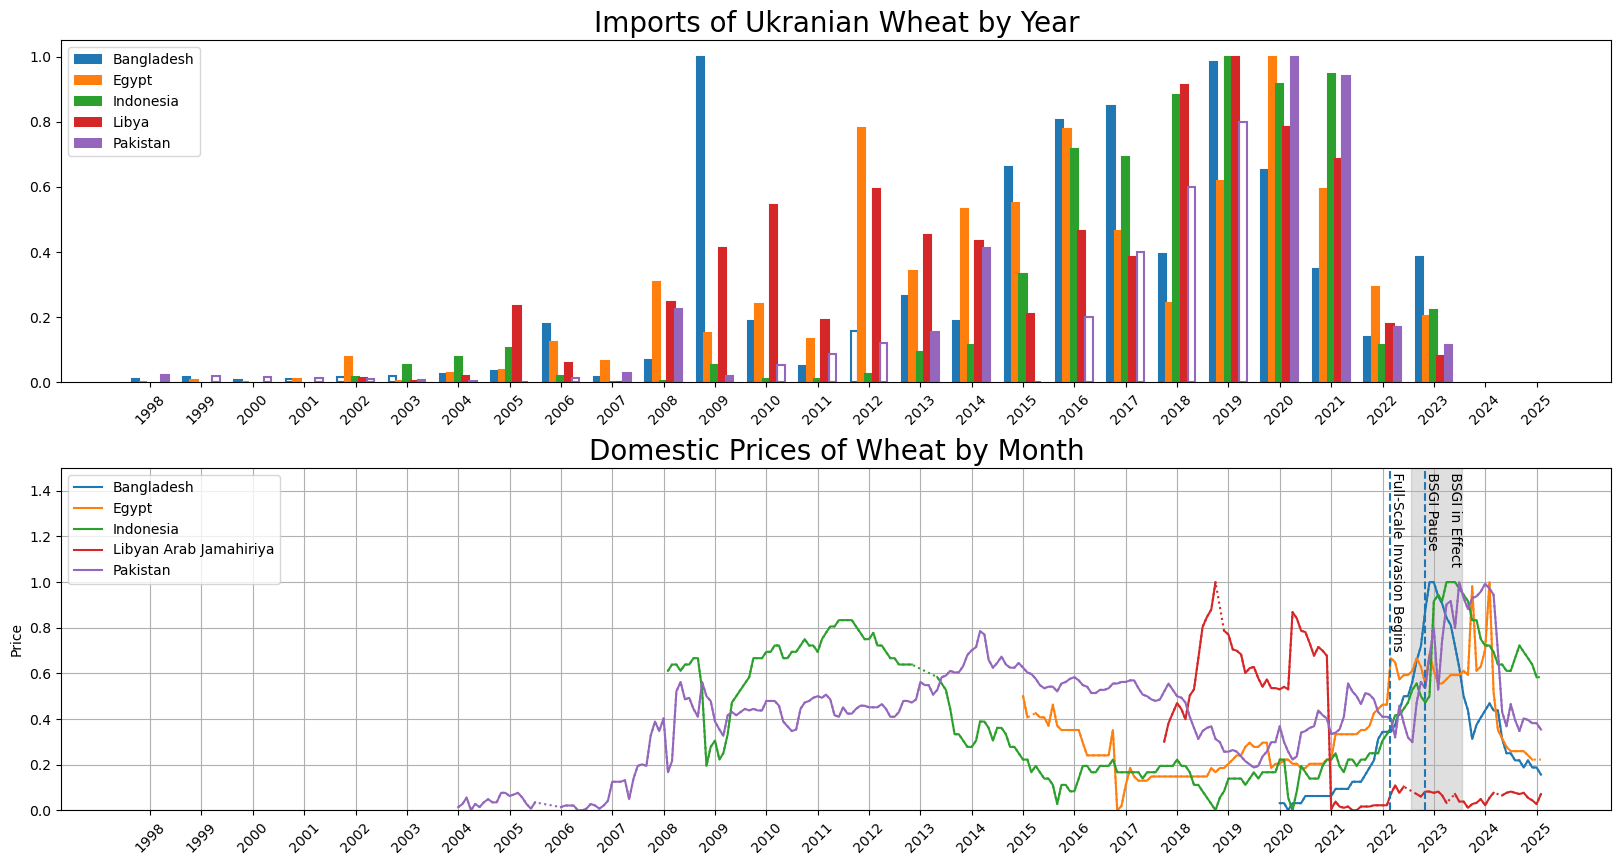

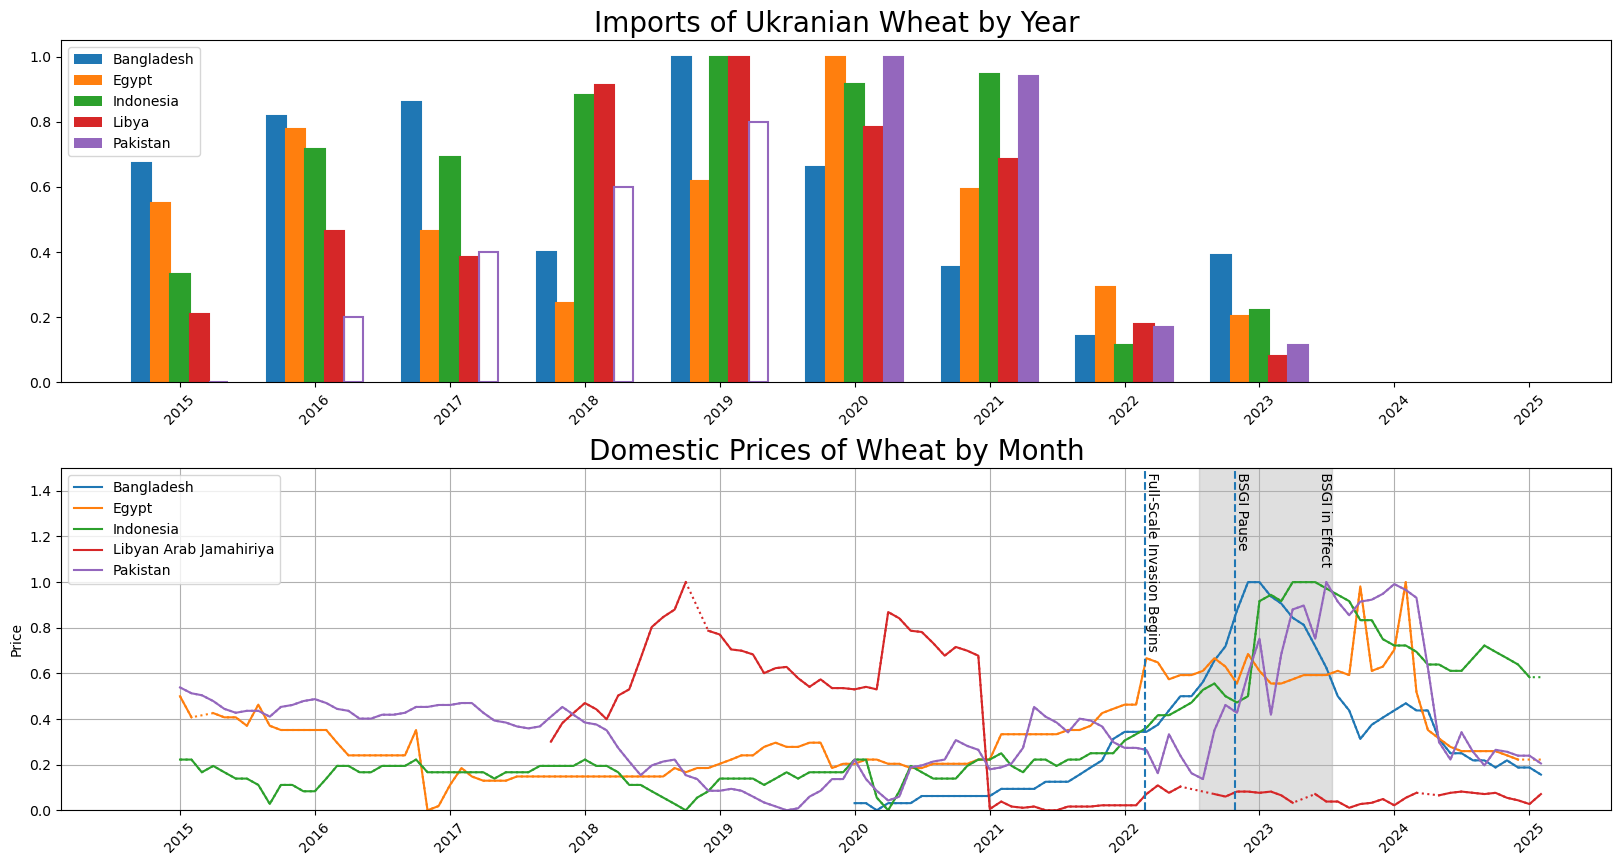

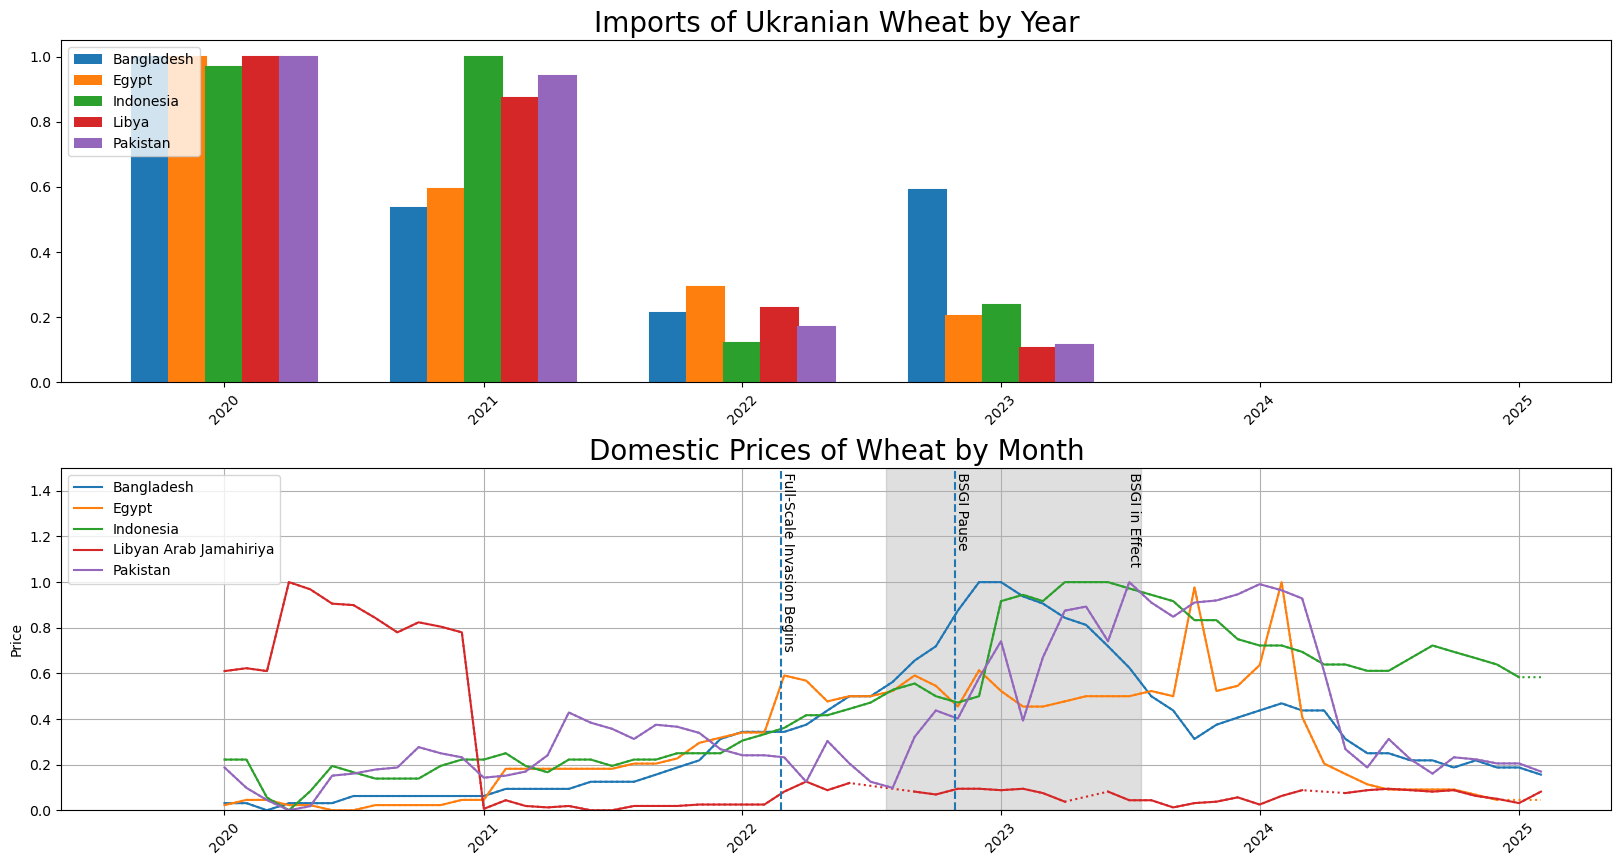

In [28]:
# Plot import hist and price line on same x axis
# Bar is normed by max value, line is min-max normed
histLinePlot(interpPrices, interpExports)
histLinePlot(interpPrices, interpExports, start=pd.to_datetime("2015-01-01"))
histLinePlot(interpPrices, interpExports, start=pd.to_datetime("2020-01-01"))

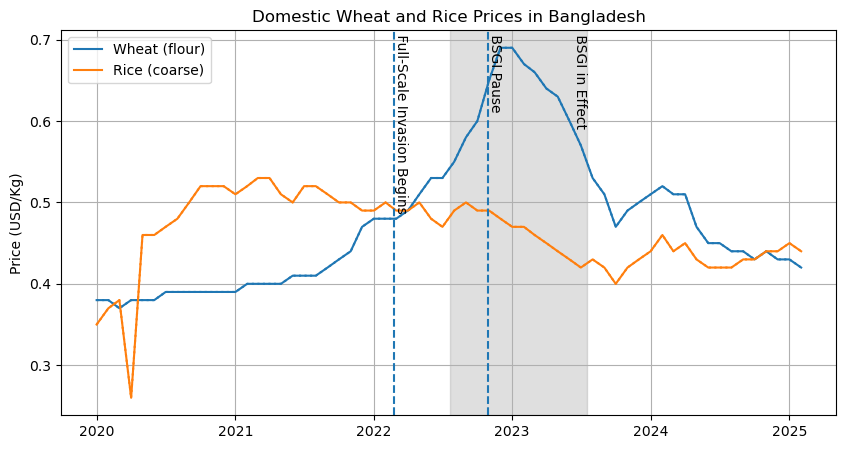

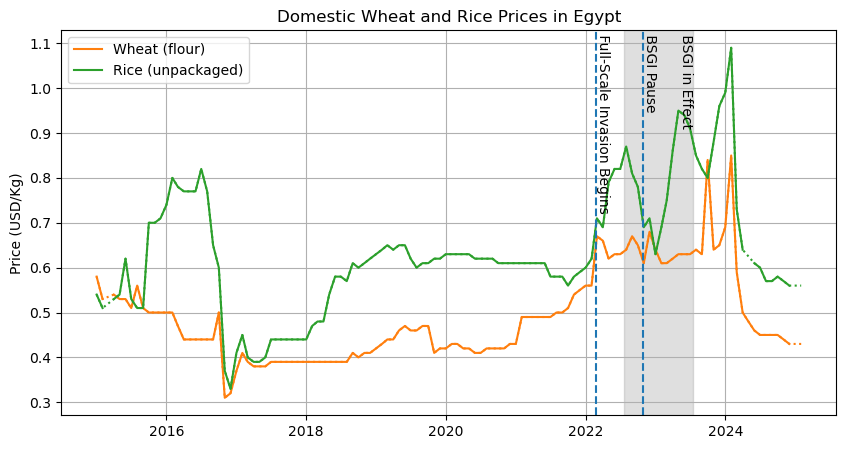

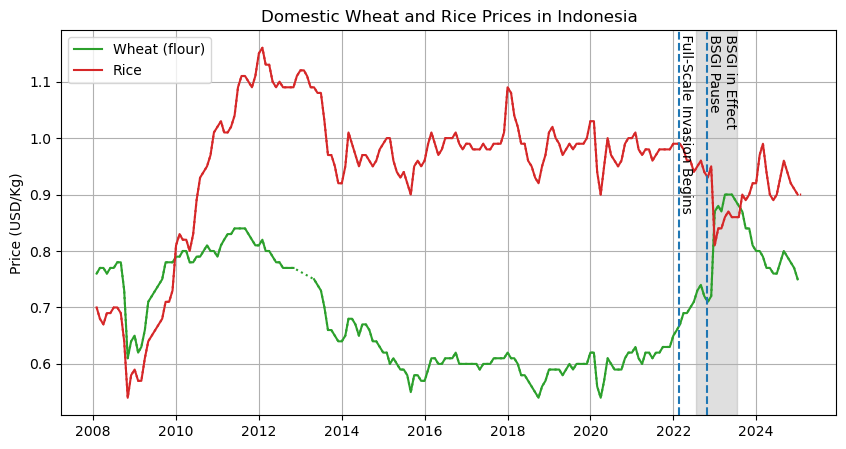

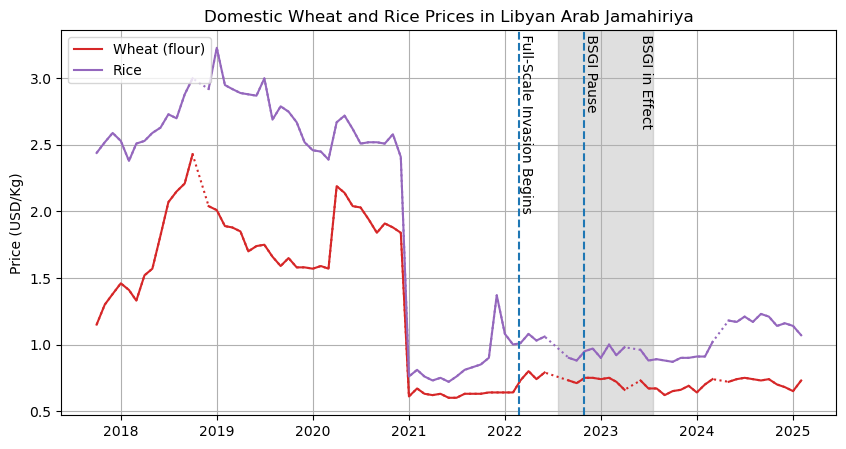

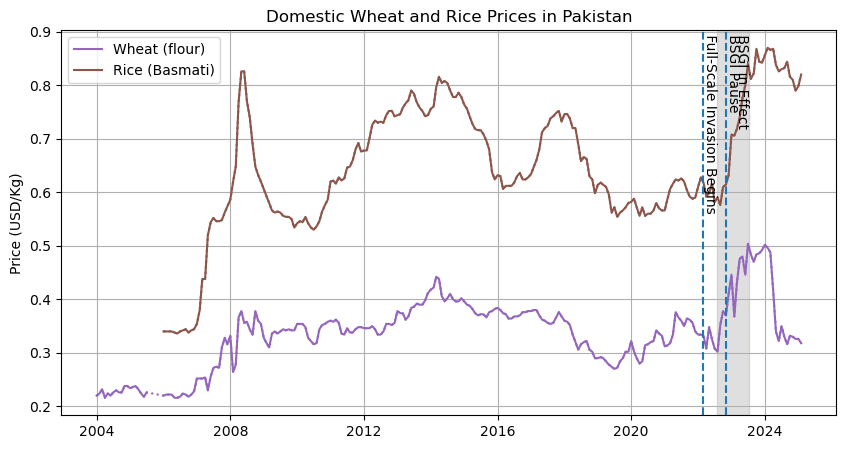

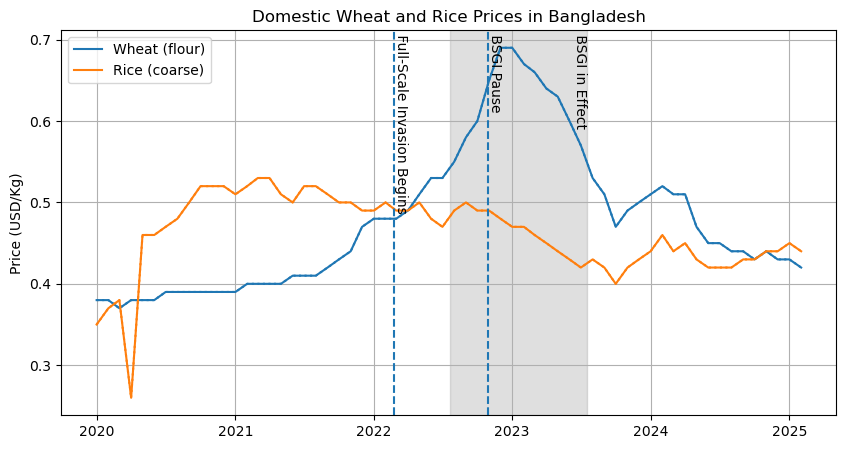

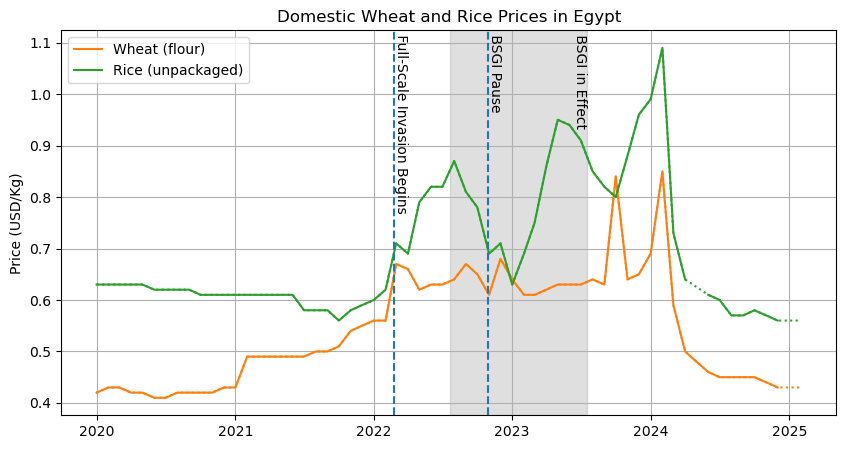

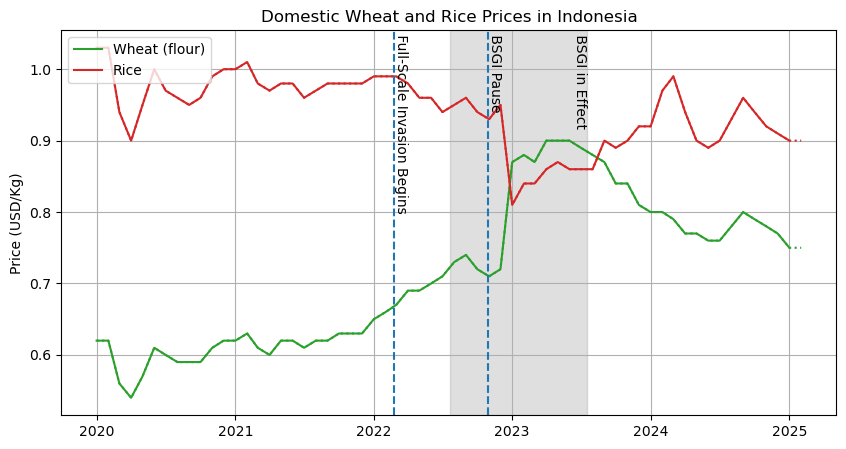

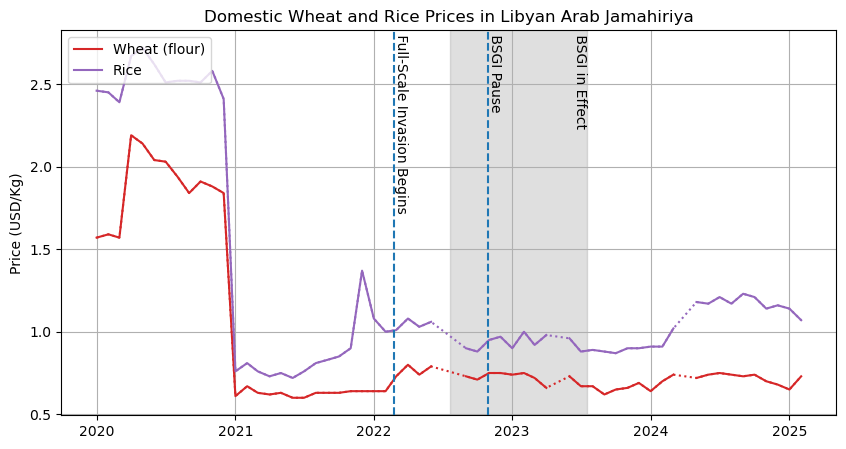

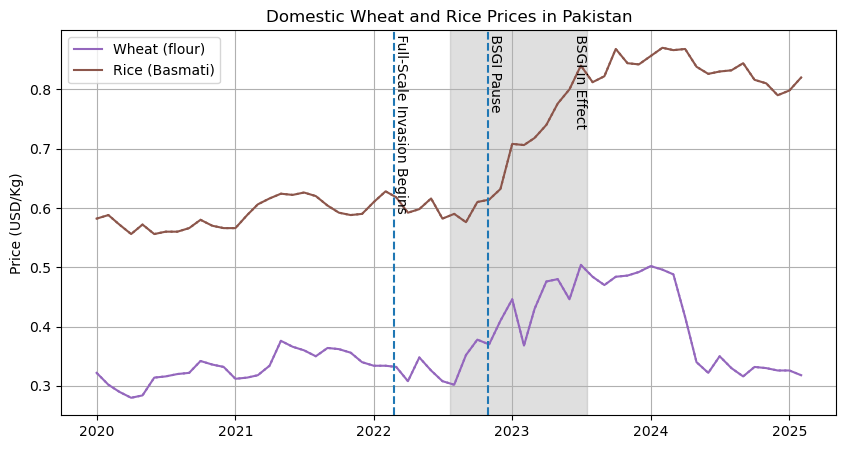

In [29]:
# Plot rice and wheat raw prices from 2020-2024 (also get correlations between wheat and control [rice])
# Not normalized
corrsFullRange = controlCompare(interpPrices, interpControls)
corrsAfter2020 = controlCompare(interpPrices, interpControls, start=pd.to_datetime("2020-01-01"))

### Correlation & Significance

In [30]:
# Display correlation values and significance for each country, comparing within war or BSGI with other
countries = ["Bangladesh", "Egypt", "Indonesia", "Libya", "Pakistan"]
df = pd.DataFrame(corrsFullRange).T
print(" ---- FOR FULL DATA RANGE ---- ")
for country in countries: # Compare entire data range correlation to BSGI and War range
	display(df[df.index.str.contains(country)])
display(df)

df = pd.DataFrame(corrsAfter2020).T
print("\n\n ---- FOR 2020 ON ---- ")
for country in countries: # Compare 2020 on correlation to BSGI and War range
	display(df[df.index.str.contains(country)])
display(df)

 ---- FOR FULL DATA RANGE ---- 


,rIn,pIn,rOut,pOut
Bangladesh War Correlations,0.453396,0.005484,0.353786,0.076214
Bangladesh BSGI Correlations,0.064685,0.841700,-0.038888,0.788603


,rIn,pIn,rOut,pOut
Egypt War Correlations,0.755346,3.761482e-07,0.404308,1.242674e-04
Egypt BSGI Correlations,-0.024169,9.405678e-01,0.703941,3.873361e-17


,rIn,pIn,rOut,pOut
Indonesia War Correlations,-0.789889,1.685251e-08,-0.056551,0.471988
Indonesia BSGI Correlations,-0.900203,6.579581e-05,-0.077320,0.292880


,rIn,pIn,rOut,pOut
Libyan Arab Jamahiriya War Correlations,0.394782,0.025347,0.922645,2.474267e-22
Libyan Arab Jamahiriya BSGI Correlations,0.256360,0.474638,0.948088,1.478038e-37


,rIn,pIn,rOut,pOut
Pakistan War Correlations,0.454808,0.005322,0.820713,1.473496e-48
Pakistan BSGI Correlations,0.871274,0.000223,0.779756,8.195459e-46


,rIn,pIn,rOut,pOut
Bangladesh War Correlations,0.453396,5.484462e-03,0.353786,7.621358e-02
Bangladesh BSGI Correlations,0.064685,8.416997e-01,-0.038888,7.886029e-01
Egypt War Correlations,0.755346,3.761482e-07,0.404308,1.242674e-04
Egypt BSGI Correlations,-0.024169,9.405678e-01,0.703941,3.873361e-17
Indonesia War Correlations,-0.789889,1.685251e-08,-0.056551,4.719875e-01
Indonesia BSGI Correlations,-0.900203,6.579581e-05,-0.077320,2.928800e-01
Libyan Arab Jamahiriya War Correlations,0.394782,2.534660e-02,0.922645,2.474267e-22
Libyan Arab Jamahiriya BSGI Correlations,0.256360,4.746378e-01,0.948088,1.478038e-37
Pakistan War Correlations,0.454808,5.322445e-03,0.820713,1.473496e-48
Pakistan BSGI Correlations,0.871274,2.233901e-04,0.779756,8.195459e-46




 ---- FOR 2020 ON ---- 


,rIn,pIn,rOut,pOut
Bangladesh War Correlations,0.453396,0.005484,0.353786,0.076214
Bangladesh BSGI Correlations,0.064685,0.841700,-0.038888,0.788603


,rIn,pIn,rOut,pOut
Egypt War Correlations,0.755346,3.761482e-07,-0.626357,6.187901e-04
Egypt BSGI Correlations,-0.024169,9.405678e-01,0.813693,3.594850e-12


,rIn,pIn,rOut,pOut
Indonesia War Correlations,-0.789889,1.685251e-08,0.745609,0.000012
Indonesia BSGI Correlations,-0.900203,6.579581e-05,-0.630487,0.000001


,rIn,pIn,rOut,pOut
Libyan Arab Jamahiriya War Correlations,0.394782,0.025347,0.977374,1.058825e-17
Libyan Arab Jamahiriya BSGI Correlations,0.256360,0.474638,0.975840,4.919730e-32


,rIn,pIn,rOut,pOut
Pakistan War Correlations,0.454808,0.005322,0.654996,2.821328e-04
Pakistan BSGI Correlations,0.871274,0.000223,0.632441,8.351784e-07


,rIn,pIn,rOut,pOut
Bangladesh War Correlations,0.453396,5.484462e-03,0.353786,7.621358e-02
Bangladesh BSGI Correlations,0.064685,8.416997e-01,-0.038888,7.886029e-01
Egypt War Correlations,0.755346,3.761482e-07,-0.626357,6.187901e-04
Egypt BSGI Correlations,-0.024169,9.405678e-01,0.813693,3.594850e-12
Indonesia War Correlations,-0.789889,1.685251e-08,0.745609,1.235049e-05
Indonesia BSGI Correlations,-0.900203,6.579581e-05,-0.630487,1.202540e-06
Libyan Arab Jamahiriya War Correlations,0.394782,2.534660e-02,0.977374,1.058825e-17
Libyan Arab Jamahiriya BSGI Correlations,0.256360,4.746378e-01,0.975840,4.919730e-32
Pakistan War Correlations,0.454808,5.322445e-03,0.654996,2.821328e-04
Pakistan BSGI Correlations,0.871274,2.233901e-04,0.632441,8.351784e-07
